In [1]:
# Data management
import pandas as pd 
import os 
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)

# Data processing and unit conversions
import numpy as np
import ast
import scipy
from scipy.spatial.transform import Rotation

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib.patches import Patch

## Load data

##### Basic preprocessing functions

In [2]:
def expand_coordinates(df):
    """Reads coordinates (stored as tuples in the CSV) into separate columns"""
    for col in df.columns:
        if str(df[col][0]).startswith('('): # check if tuple
            if type(df[col][0]) == str: # check if tuple is stored as string
                df[col] = df[col].apply(ast.literal_eval) # convert string -> tuple
            n_dims = len(df[col][0]) # inspect first element: 2D, 3D or 4D coordinates
            suffix = 'WXYZ' if n_dims==4 else 'XYZ' # if 4D coordinates (quaternion), the first is W
            new_col_labels = [col+suffix[i] for i in range(n_dims)] # labels with suffix
            new_columns = pd.DataFrame(df[col].to_list(), index=df.index) # expand tuples to separate colunms
            df[new_col_labels] = new_columns

def add_conditions_from_trial_data(df, trial_data, conditions):
    """Lookup the trial conditions in trial_data and add to df"""
    for condition in conditions:
        lookup = trial_data.set_index('TrialIdentifier')[condition].to_dict() # map ID -> condition
        df[condition] = df.TrialIdentifier.replace(lookup) # add condition to df

def quat_to_euler(x):
    if type(x) == str:
        quat_tuple = ast.literal_eval(x) # convert string -> tuple
    quat_obj = Rotation.from_quat(quat_tuple)
    # return quat_obj.as_euler('xyz', degrees=True)
    return quat_obj.as_euler('XYZ', degrees=True)

def quat_to_dir(x):
    if type(x) == str:
        quat_tuple = ast.literal_eval(x) # convert string -> tuple
    quat_obj = Rotation.from_quat(quat_tuple)
    return tuple(quat_obj.apply([0,0,1]))

def preprocess_data(exp_data, trial_configs=None):
    if trial_configs is None:
        trial_configs = exp_data['TrialConfigRecord']

    for data_key in exp_data.keys():
        dataframe = exp_data[data_key]

        # Copy some useful columns from the TrialConfigRecord dataframe to the other dataframes
        if data_key != 'TrialConfigRecord':
            add_conditions_from_trial_data(dataframe,
                                                                         trial_configs,
                                                                         ['ExperimentalTask', 'Block', 'GazeCondition', 'Subject'])

        # Convert Quaternions to normalized direction vector (in separate column)
        rot_cols = [col for col in dataframe.columns if 'Rot' in col]
        if rot_cols:
            dir_cols = [col.replace('Rot', 'Dir') for col in rot_cols]
            dataframe[dir_cols] = dataframe.apply({col: quat_to_dir for col in rot_cols})

        # Put coordinates in separate columns (instead of tuples)
        expand_coordinates(dataframe)

    return


##### Basic save/load functions

In [9]:
def save_preprocessed_data(exp_data, calibr_data, data_dir):
    save_dir = os.path.join(data_dir,'_preprocessed')
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    for data_key, dataframe in exp_data.items():
        fn = os.path.join(save_dir,f'{data_key}.tsv')
        dataframe.to_csv(fn, sep = '\t', index=False)

    for data_key, dataframe in calibr_data.items():
        fn = os.path.join(data_dir,'_preprocessed',f'calibrationTest_{data_key}.tsv')
        dataframe.set_index('TrialIdentifier').to_csv(fn, sep = '\t', index=False)

def load_preprocessed_data(data_dir):
    exp_data, calibr_data = dict(), dict()
    path = os.path.join(data_dir,'_preprocessed')
    files = os.listdir(path)
    for fn in files:
        data_key = fn.replace('calibrationTest_', '').replace('.tsv', '')
        if 'calibration' in fn:
            calibr_data[data_key] = pd.read_csv(os.path.join(path,fn),sep='\t')
        else:
            exp_data[data_key] = pd.read_csv(os.path.join(path,fn),sep='\t')
    return exp_data, calibr_data

def get_filenames(subjects, data_dir, data_keys=None):
    """Returns dict with filenames for all specified subjects found in the data 
    directory. The filenames are indexed by record type. """
    # Initialize dict with filenames (categorized by record type)
    if data_keys is None:
        data_keys = ['TrialConfigRecord', 'SingleEyeDataRecordR', 'SingleEyeDataRecordL',
                    'SingleEyeDataRecordC', 'EyeTrackerDataRecord', 'EngineDataRecord']
    data_files = {k: [] for k in data_keys}
    calibr_files = {k: [] for k in data_keys}

    # Add all files per subject
    for subj in subjects:
        base_path = os.path.join(data_dir,subj)
        listdir = sorted([os.path.join(base_path,fn) for fn in os.listdir(base_path) if 'tsv' in fn])
        for key in data_keys:
            data_files[key] += [fn for fn in listdir if (key in fn) and (not 'calibration' in fn)]
            calibr_files[key] += [fn for fn in listdir if (key in fn) and ('calibration' in fn)]
    calibr_files = {k: v for k, v in calibr_files.items() if v} # remove empty keys
    return data_files, calibr_files

def load_data_from_filenames(filenames_dict, downsample=None, **pd_kwargs):
    """For each item in filenames dict, reads the listed TSV files and concatenate
     in a single dataframe. Returns dict with pandas dataframes."""
    # The output dict
    exp_data = dict()
    downsample_rate = 1 if downsample is None else downsample

    # Loop through data keys ('TrialConfigRecord', 'SingleEyeDataRecordC', 'EngineDataRecord', etc.)
    for data_key, filenames in filenames_dict.items():

        # Put all trials (for all subjects) in a single dataframe
        dataframe = None
        for i in range(len(filenames)):

            # Read new rows from file
            new = pd.read_csv(filenames[i],sep = '\t', **pd_kwargs)
            
            if data_key in ['EngineDataRecord', 'SingleEyeDataRecordR', 'SingleEyeDataRecordL', 'SingleEyeDataRecordC']:
                new = new[::downsample_rate].copy()

            # Get block number, trial and subject from filename and directory
            path, fn = os.path.split(filenames[i])
            subject = os.path.basename(path).replace('_','')
            block = int(fn[0:2])
            relative_trial_number = int(fn[3:5])
            identifier = f'{subject}B{block}T{relative_trial_number}'
            new['Subject'] = subject
            new['Block'] = block
            new['RelativeTrialNumber'] = relative_trial_number
            new['TrialIdentifier'] = identifier

            # Append new rows to the dataframe
            if dataframe is None:
                dataframe = new
            else:
                dataframe = pd.concat([dataframe,new], ignore_index = True)

        # Add the dataframe to the output dict
        exp_data[data_key] = dataframe
    return exp_data

##### Load the dataframes

In [4]:
# Which data to read
DATA_DIR = '../_Datasets/SPVGazeData'
# DATA_DIR = '/content/gdrive/MyDrive/SPVGazeData'
SUBJECTS = {'S35', 'S37', 'S38', 'S39', 'S40', 'S41', 'S42', 'S45', 'S46',
            'S47', 'S49', 'S50', 'S51', 'S52', 'S53', 'S54', 'S55', 'S56', 'S57'} # Pilot subjects:"'S30', 'S30_','S31', 's33', 's33_', 'S34', 'S34_'"
LOAD_PREPROCESSED = False
DATA_KEYS = ['TrialConfigRecord', 'EngineDataRecord', 'SingleEyeDataRecordC']
DOWNSAMPLE = 1


if LOAD_PREPROCESSED:
    
    ## Load preprocessed data
    EXP_DATA, CALIBR_DATA = load_preprocessed_data(DATA_DIR)

    ## Check whether subjects are missing
    existing = EXP_DATA['TrialConfigRecord'].Subject.unique()
    new_subjects = [subj for subj in SUBJECTS if subj[:3] not in existing]
    
    print(f"Loaded data for subjects:{existing}\n\n")

    ## If not in dataframe, add new subjects 
    if new_subjects:
        print(f"Adding new subjects: {new_subjects}")
        # Load filenames 
        data_files, calibr_files = get_filenames(new_subjects,DATA_DIR)

        # Load the trial data
        new_exp_data = load_data_from_filenames(data_files)
        new_clb_data = load_data_from_filenames(calibr_files, )

        # Preprocess data
        preprocess_data(new_exp_data)
        preprocess_data(new_clb_data, trial_configs=new_exp_data['TrialConfigRecord'])

        # Add to dataframe
        for data_key in new_exp_data.keys():
            EXP_DATA[data_key] = pd.concat([EXP_DATA[data_key],
                                                                            new_exp_data[data_key]],
                                                                            ignore_index = True)
        for data_key in new_clb_data.keys():
            CALIBR_DATA[data_key] = pd.concat([CALIBR_DATA[data_key],
                                                                            new_clb_data[data_key]],
                                                                            ignore_index = True)
else:
    
    ## Load filenames 
    data_files, calibr_files = get_filenames(SUBJECTS,DATA_DIR, DATA_KEYS)

    ## Load the trial data
    EXP_DATA = load_data_from_filenames(data_files, DOWNSAMPLE)
    CALIBR_DATA = load_data_from_filenames(calibr_files, DOWNSAMPLE)

    ## Preprocess data
    preprocess_data(EXP_DATA)
    preprocess_data(CALIBR_DATA, trial_configs=EXP_DATA['TrialConfigRecord'])

SUBJECTS = SUBJECTS.intersection(EXP_DATA['TrialConfigRecord'].Subject.unique())

<AxesSubplot: xlabel='Subject', ylabel='TrialDuration'>

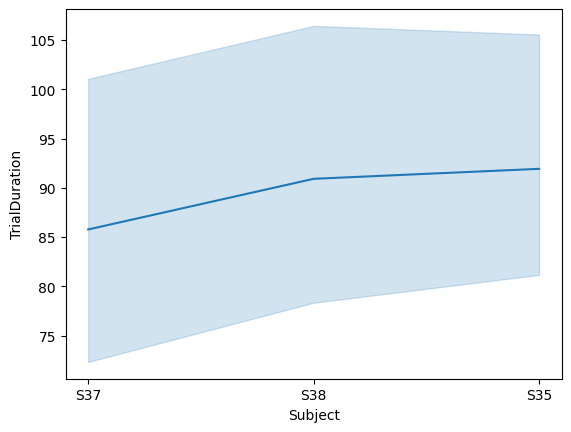

In [9]:
sns.lineplot(x='Subject', y='TrialDuration', data=EXP_DATA['TrialConfigRecord'])

In [5]:
# save_preprocessed_data(EXP_DATA, CALIBR_DATA,DATA_DIR)

In [6]:
# # Use data from subjects only
# for data_key in EXP_DATA.keys():
#         subj_mask = EXP_DATA[data_key].Subject.isin(SUBJECTS)
#         EXP_DATA[data_key] = EXP_DATA[data_key].loc[subj_mask].copy()
# for data_key in CALIBR_DATA.keys():
#         subj_mask = CALIBR_DATA[data_key].Subject.isin(SUBJECTS)
#         CALIBR_DATA[data_key] = CALIBR_DATA[data_key].loc[subj_mask].copy()

## Eye tracking data analysis

##### Plotting functions

In [34]:
def plot_gaze_maps(data):
    fig, axs = plt.subplots(1,3,figsize=(12,4), dpi=100)
    for i, condition in enumerate(data.GazeCondition.unique()):
        mask = data.GazeCondition == condition
        plot_single_gaze_map(data.loc[mask], ax=axs[i], title=condition)
    return fig, axs

def plot_single_gaze_map(data, fig=None, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(4,4), dpi=100)
    ax.scatter(data['GazeDirectionNormInEyeX'],
                            data['GazeDirectionNormInEyeY'], alpha = 0.002, color='#9e1111')
    ax.axis('square')
    ax.set(xlim = [-0.8,0.8],
                        ylim = [-0.8,0.8], title=title)
    return fig, ax


##### Generate gaze plots

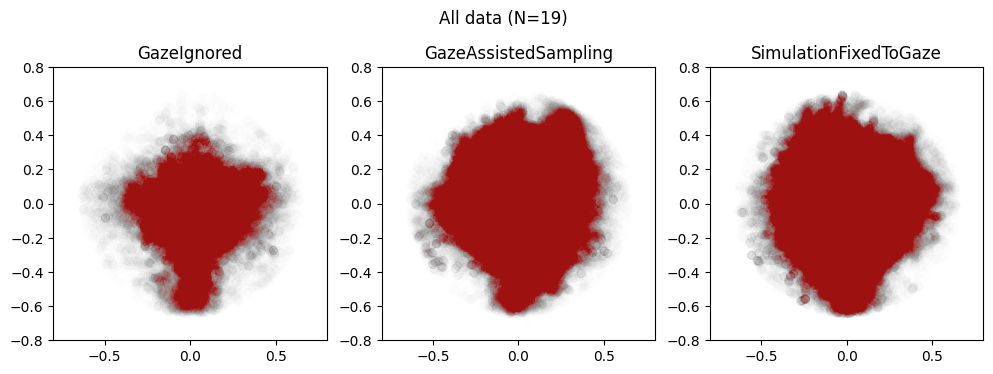

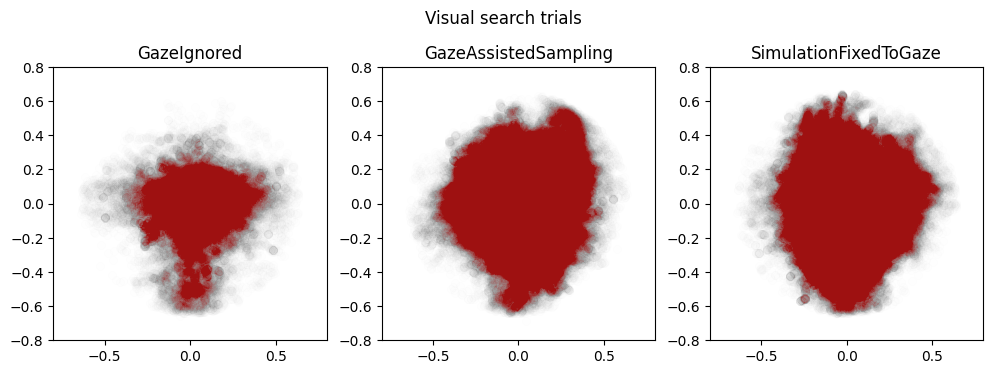

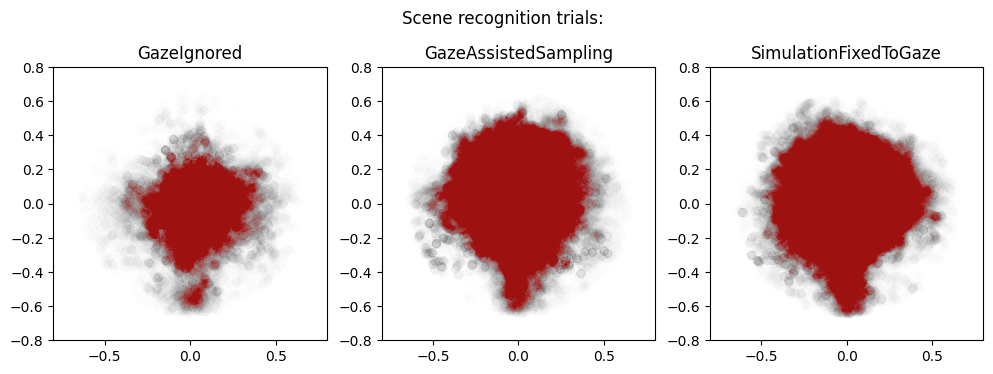

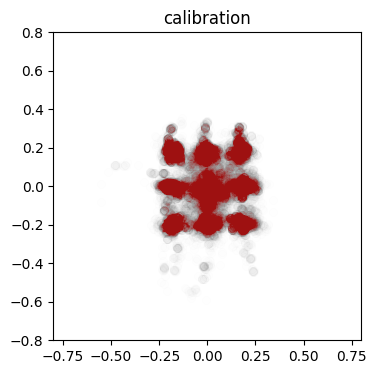

In [35]:
## Which data to show
subjects = SUBJECTS # or specify list of subjects of interest

## Load the eye tracking data
data = EXP_DATA['SingleEyeDataRecordC'].copy()
data = data.loc[data.Block>0] # Exclude practice block
data = data.loc[(data.Subject.isin(subjects))] # Specified subjects

 
# All data
fig,_ = plot_gaze_maps(data)
fig.suptitle(f'All data (N={len(subjects)})')

# Visual search data
fig,_= plot_gaze_maps(data.loc[data.ExperimentalTask == 'VisualSearch'])
fig.suptitle('Visual search trials')

# Scene recognition data
fig,_= plot_gaze_maps(data.loc[data.ExperimentalTask == 'SceneRecognition'])
fig.suptitle('Scene recognition trials:')

# Calibration data
data = CALIBR_DATA['SingleEyeDataRecordC'].copy()
data = data.loc[(data.Subject.isin(subjects))] # Specified subjects
_ = plot_single_gaze_map(data, title='calibration')

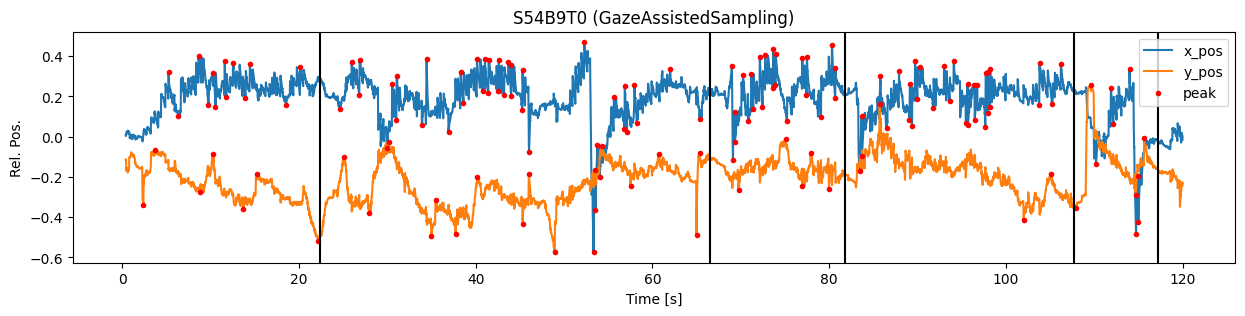

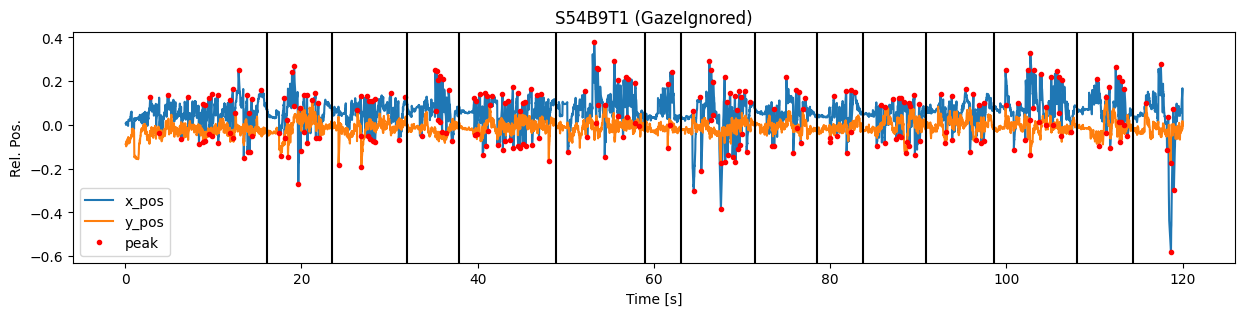

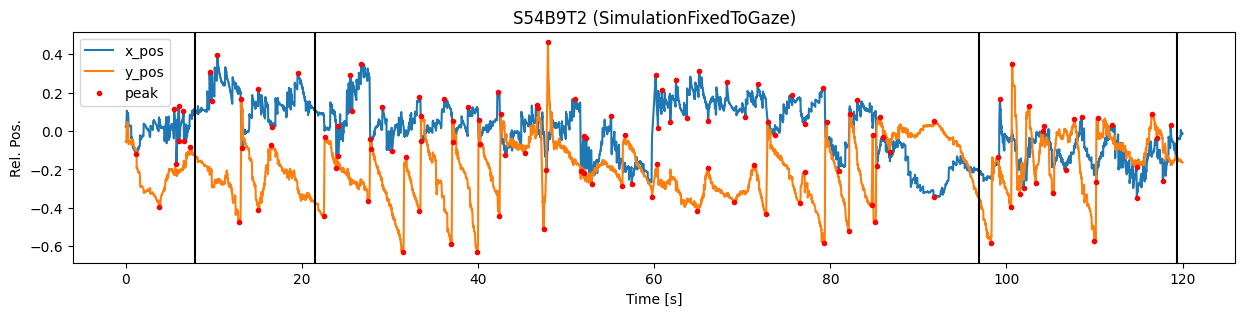

In [36]:
def plot_time_series(trial_identifier, remove_missing=False, peak_prominence=0.15):
    eye_data = EXP_DATA['SingleEyeDataRecordC'].set_index('TrialIdentifier').loc[trial_identifier].copy().reset_index()
    trial_data = EXP_DATA['TrialConfigRecord'].set_index('TrialIdentifier').loc[trial_identifier].copy()
    engine_data =  EXP_DATA['EngineDataRecord'].set_index('TrialIdentifier').loc[trial_identifier].copy().reset_index()

    
    fig, ax = plt.subplots(figsize=(15,3),dpi=100)
    
     # Calculate elapsed time for each trial
    for data in [eye_data, engine_data]:
        start_of_trial = data.ne(data.shift()).TrialIdentifier # True for first frame of each trial
        t_0 = data.where(start_of_trial).TimeStamp.ffill()
        data['TimeElapsed'] = (data.TimeStamp - t_0) * 1e-7
    
    # Remove missing data
    eye_data['Missing'] = eye_data.GazeDirectionNormInEyeX == -1
    if remove_missing:
        eye_data = eye_data.loc[~eye_data.Missing]
    
    # Ignore data after trial finish
    eye_data = eye_data.loc[eye_data.TimeElapsed <= trial_data.TrialDuration]
    
    # Extract time series
    t = eye_data.TimeElapsed
    pos_x = eye_data.GazeDirectionNormInEyeX
    pos_y = eye_data.GazeDirectionNormInEyeY
    
    # Plot x and y position of the eye
    ax.plot(t, pos_x, label = 'x_pos')
    ax.plot(t, pos_y, label = 'y_pos')
    
    # Find peaks 
    x_peaks = scipy.signal.find_peaks(pos_x, prominence=peak_prominence)[0].tolist() # local maxima
    x_peaks += scipy.signal.find_peaks(-pos_x, prominence=peak_prominence)[0].tolist() #local minima
    y_peaks = scipy.signal.find_peaks(pos_y, prominence=peak_prominence)[0].tolist()
    y_peaks += scipy.signal.find_peaks(-pos_y, prominence=peak_prominence)[0].tolist()

    ax.plot(t.iloc[x_peaks], pos_x.iloc[x_peaks], 'r.', label = 'peak')
    ax.plot(t.iloc[y_peaks], pos_y.iloc[y_peaks], 'r.' )

        
    # Plot reported events as vertical lines    
    events = engine_data.ReportedEventsCount.diff() > 0
    for t in engine_data.loc[events].TimeElapsed:        
        ax.axvline(t, color='k')
        
    ax.legend() 
    ax.set(title=f'{trial_identifier} ({trial_data.GazeCondition})',
           xlabel = 'Time [s]',
           ylabel = 'Rel. Pos.')  

    return fig, ax
    
_, ax0 = plot_time_series('S54B9T0', remove_missing=True)
_, ax1 = plot_time_series('S54B9T1', remove_missing=True)
_, ax2 = plot_time_series('S54B9T2', remove_missing=True)

Example output:

![example_1](Out/timeseries_0.png)
![example_2](Out/timeseries_1.png)
![example_3](Out/timeseries_2.png)

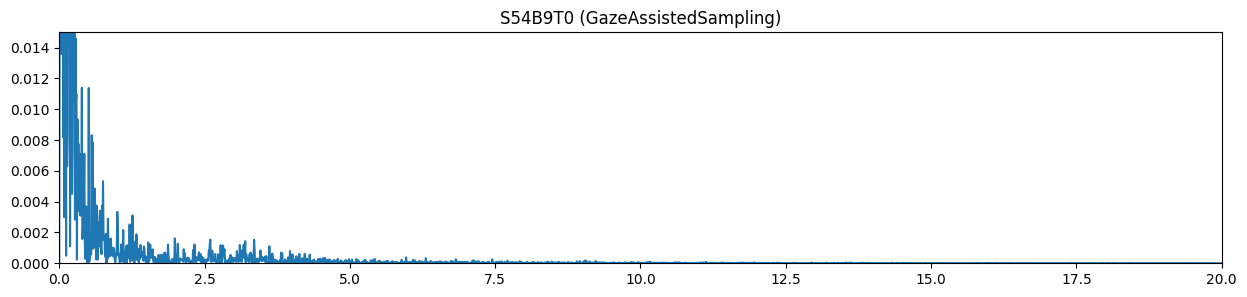

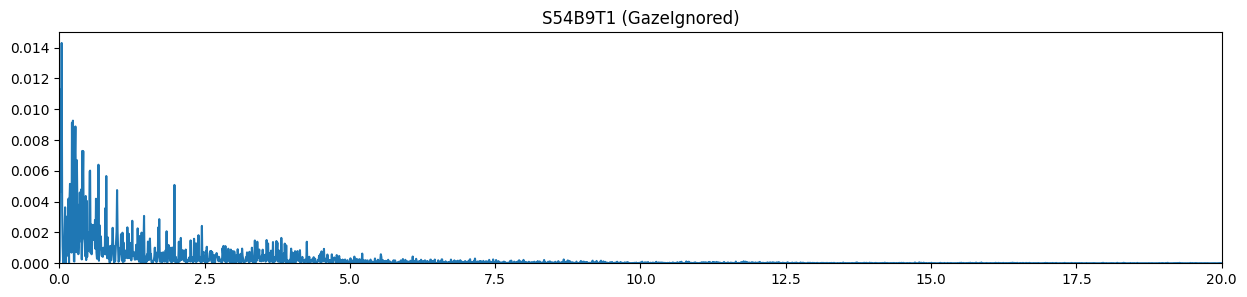

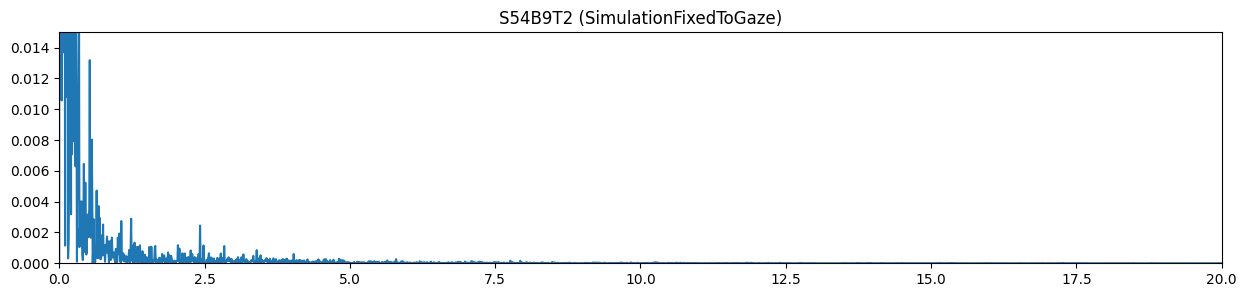

In [37]:
def plot_periodogram(trial_identifier, remove_missing=False, fs=65):
    eye_data = EXP_DATA['SingleEyeDataRecordC'].set_index('TrialIdentifier').loc[trial_identifier].copy().reset_index()
    trial_data = EXP_DATA['TrialConfigRecord'].set_index('TrialIdentifier').loc[trial_identifier].copy()
    engine_data =  EXP_DATA['EngineDataRecord'].set_index('TrialIdentifier').loc[trial_identifier].copy().reset_index()

    
    fig, ax = plt.subplots(figsize=(15,3),dpi=100)
    
     # Calculate elapsed time for each trial
    for data in [eye_data, engine_data]:
        start_of_trial = data.ne(data.shift()).TrialIdentifier # True for first frame of each trial
        t_0 = data.where(start_of_trial).TimeStamp.ffill()
        data['TimeElapsed'] = (data.TimeStamp - t_0) * 1e-7
    
    # Remove missing data
    eye_data['Missing'] = eye_data.GazeDirectionNormInEyeX == -1
    if remove_missing:
        eye_data = eye_data.loc[~eye_data.Missing]
    
    # Ignore data after trial finish
    eye_data = eye_data.loc[eye_data.TimeElapsed <= trial_data.TrialDuration]
    
    # Extract time series
    t = eye_data.TimeElapsed
    pos_x = eye_data.GazeDirectionNormInEyeX
    pos_y = eye_data.GazeDirectionNormInEyeY

#     speed = np.sqrt(pos_x**2 + pos_y**2) / t
    
    
    f, Pxx_den = scipy.signal.periodogram(pos_x,fs)
    ax.plot(f, Pxx_den)
            
#     ax.legend() 
    ax.set(title = f'{trial_identifier} ({trial_data.GazeCondition})',
          ylim = [0,0.015],
          xlim = [0,20])
           
    ax.set()

    return fig, ax
    
_, ax0 = plot_periodogram('S54B9T0', remove_missing=True)
_, ax1 = plot_periodogram('S54B9T1', remove_missing=True)
_, ax2 = plot_periodogram('S54B9T2', remove_missing=True)

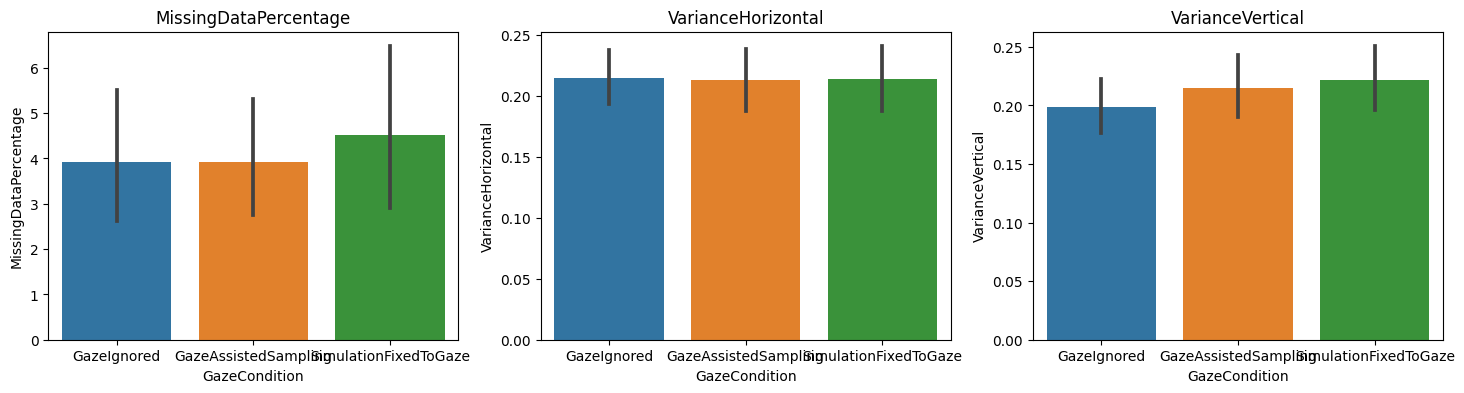

In [40]:
HUE_ORDER = ['GazeIgnored', 'GazeAssistedSampling', 'SimulationFixedToGaze'] # Use consistent colors for conditions
X_TICKVALUES = {k:i for i,k in enumerate(HUE_ORDER)} # e.g.  e.g. {GazeIgnored: 0, SimulationFixedToGaze: 1, GazeAssistedSampling: 2}
COLOR_MAPPING = {k:f'C{i}' for i,k in enumerate(HUE_ORDER)} # e.g. {GazeIgnored: 'C0', SimulationFixedToGaze: 'C1', GazeAssistedSampling: 'C2'}

def average(data, y, group='Subject', x='GazeCondition', apply_function=None):
    """Averages the endpoint variables <y> (list of column names) absover the grouping variable <group>."""
    avg = data.loc[:, [group,]+[x,] + y]
    if apply_function is None or apply_function=='mean':
        avg = avg.groupby([group, x]).mean()
    elif apply_function=='std':
        avg = avg.groupby([group, x]).std()
    else:
        avg = avg.groupby([group, x]).agg(apply_function)
    return avg.reset_index()

def bar_plots(data, endpoints, x='GazeCondition', **kwargs):
    n_figs = len(endpoints)
    fig, axs = plt.subplots(1,n_figs,figsize=(6*n_figs,4), dpi=100)
    for i, y in enumerate(endpoints):
        sns.barplot(data=data, x=x, y=y, ax= axs[i], order = HUE_ORDER, **kwargs)
        axs[i].set(title=y)
    return fig, axs

def swarm_plots(data, endpoints, group, axs=None, fig=None, jitter=0.2, alpha=0.3):
    if axs is None:
        n_figs = len(endpoints)
        fig, axs = plt.subplots(1,n_figs,figsize=(6*n_figs,4), dpi=100)
        
    x = data.GazeCondition.replace(X_TICKVALUES)
    x += jitter * (np.random.rand(len(x)) -.5) 
    x = x.sort_values()
    sorted_data = data.loc[x.index]


data = EXP_DATA['SingleEyeDataRecordC'].copy()


# Calculate elapsed time for each trial
start_of_trial = data.ne(data.shift()).TrialIdentifier # True for first frame of each trial
t_0 = data.where(start_of_trial).TimeStamp.ffill()
data['TimeElapsed'] = (data.TimeStamp - t_0) * 1e-7

# Mark missing data (for later removal)
data['Missing'] = data.GazeDirectionNormInEyeX == -1
group_idx = ['Subject', 'TrialIdentifier','GazeCondition']
perc_missing = data.groupby(group_idx).Missing.mean() * 100
reindexed = data.set_index(group_idx)
reindexed['MissingDataPercentage'] = perc_missing.loc[reindexed.index]

reindexed['VarianceHorizontal'] = data.groupby(group_idx).GazeDirectionNormInEyeX.std()
reindexed['VarianceVertical'] = data.groupby(group_idx).GazeDirectionNormInEyeY.std()

# Plot data averaged over subjects
endpoints = ['MissingDataPercentage', 'VarianceHorizontal', 'VarianceVertical']
group = 'Subject'
avg = average(data=reindexed.reset_index(), y=endpoints)

fig, axs = bar_plots(data=avg, endpoints=endpoints)
swarm_plots(data=avg, endpoints=endpoints, group=group, axs=axs)

## Trial config analysis

##### Plotting functions

In [41]:
def violin_plots(data, endpoints):
    n_figs = len(endpoints)
    fig, axs = plt.subplots(1,n_figs,figsize=(6*n_figs,4), dpi=100)
    for i, y in enumerate(endpoints):
        sns.violinplot(data=data, x='GazeCondition', y=y, ax= axs[i], order = HUE_ORDER)
        axs[i].set(title=y)
    return fig, axs

def bar_plots(data, endpoints, x='GazeCondition', **kwargs):
    n_figs = len(endpoints)
    fig, axs = plt.subplots(1,n_figs,figsize=(6*n_figs,4), dpi=100)
    for i, y in enumerate(endpoints):
        sns.barplot(data=data, x=x, y=y, ax= axs[i], order = HUE_ORDER, **kwargs)
        axs[i].set(title=y)
    return fig, axs

def swarm_plots(data, endpoints, group, axs=None, fig=None, jitter=0.2, alpha=0.3):
    if axs is None:
        n_figs = len(endpoints)
        fig, axs = plt.subplots(1,n_figs,figsize=(6*n_figs,4), dpi=100)
        
    x = data.GazeCondition.replace(X_TICKVALUES)
    x += jitter * (np.random.rand(len(x)) -.5) 
    x = x.sort_values()
    sorted_data = data.loc[x.index]
    
    for i, y in enumerate(endpoints):
#         sns.swarmplot(data=data, x=x, y=y, ax= axs[i], order = HUE_ORDER, **kwargs)
#         sns.stripplot(data=data, x=x, y=y, ax= axs[i], order = HUE_ORDER, **kwargs)

        for category in data[group].unique():
            mask = sorted_data[group] == category
            colors = sorted_data.loc[mask,'GazeCondition'].replace(COLOR_MAPPING)
            axs[i].plot(x.loc[mask], sorted_data.loc[mask,y], linestyle=':', color='k', alpha=alpha )
            axs[i].scatter(x.loc[mask], sorted_data.loc[mask,y], linestyle=':',color=colors, )
            axs[i].set(title=y)
    return fig, axs

##### Generate violin plots (General outcomes, raw data)

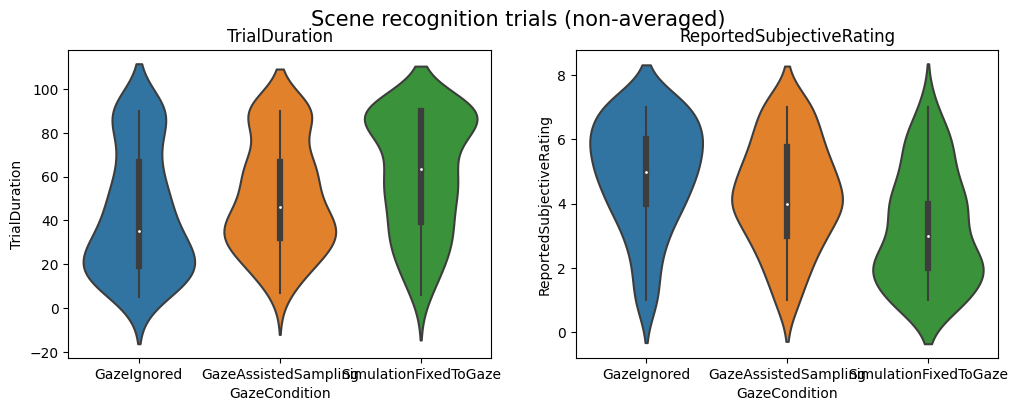

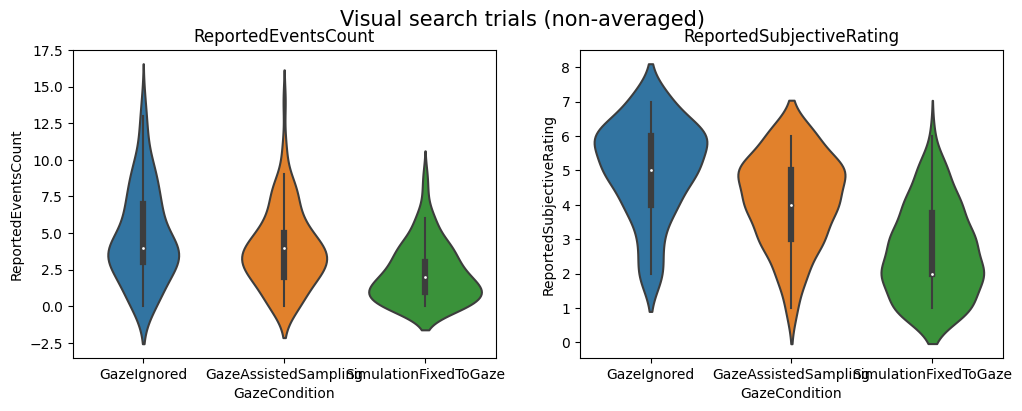

In [42]:
## Which data to show
subjects = SUBJECTS # or specify list of subjects of interest

## Load the eye tracking data
data = EXP_DATA['TrialConfigRecord'].copy()
data = data.loc[data.Block>0] # Exclude practice block
data = data.loc[(data.Subject.isin(subjects))] # Specified subjects
data = data.astype({'ReportedSubjectiveRating':float, 'ReportedEventsCount':float})


# Scene recognition
SR_mask = data.ExperimentalTask == 'SceneRecognition'
fig, axs = violin_plots(data.loc[SR_mask], ['TrialDuration','ReportedSubjectiveRating'])
fig.suptitle('Scene recognition trials (non-averaged)', fontsize=15)

# Visual search
VS_mask = data.ExperimentalTask == 'VisualSearch'
fig, axs = violin_plots(data.loc[VS_mask], ['ReportedEventsCount', 'ReportedSubjectiveRating'])
fig.suptitle('Visual search trials (non-averaged)', fontsize=15)

# fig.tight_layout()
plt.show()

#### Scene Recognition analysis

Text(0.5, 0.98, 'Second observation (grouped)')

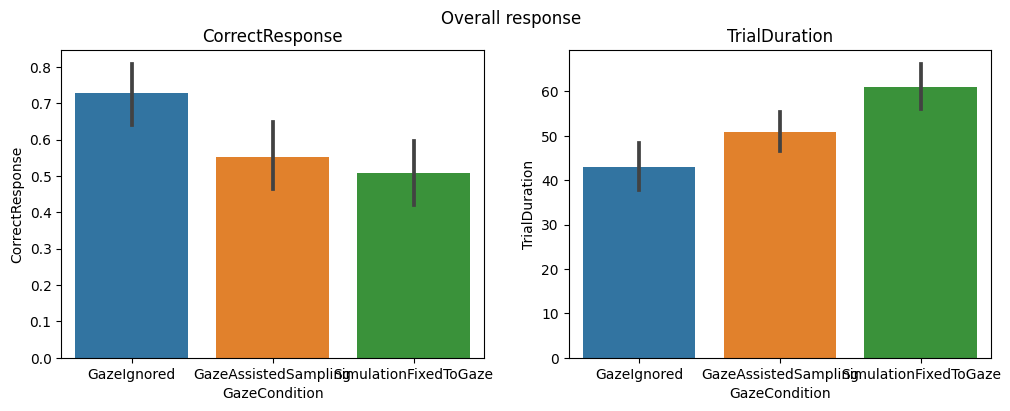

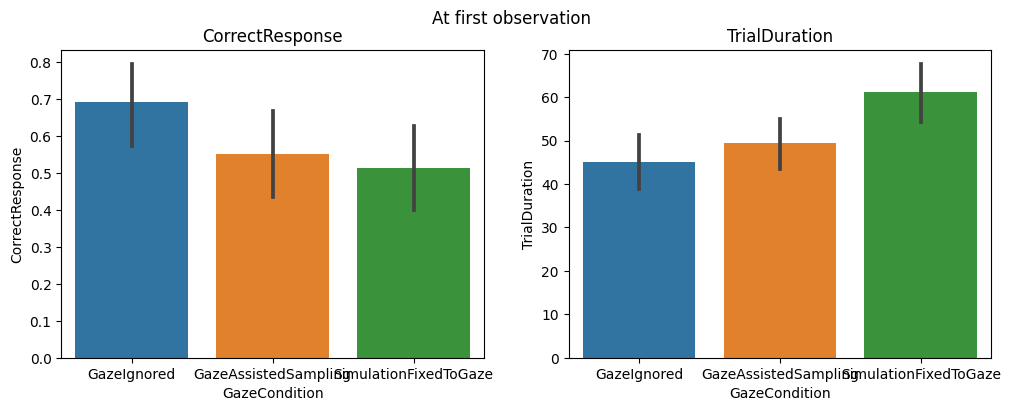

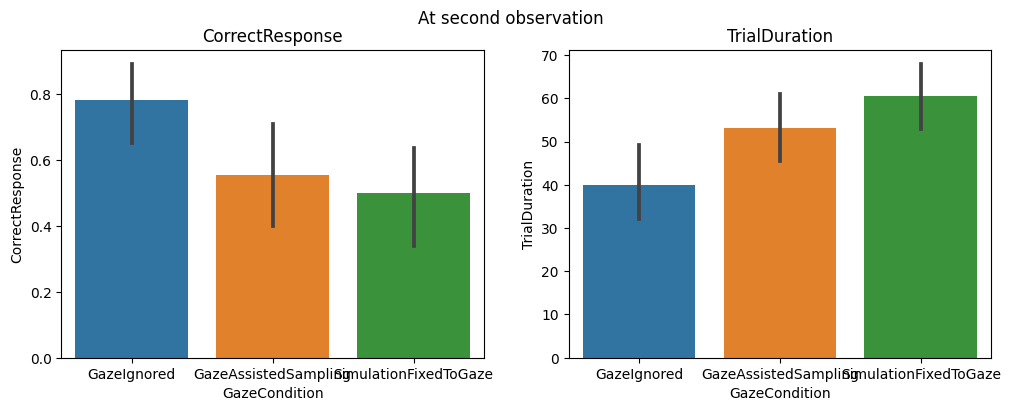

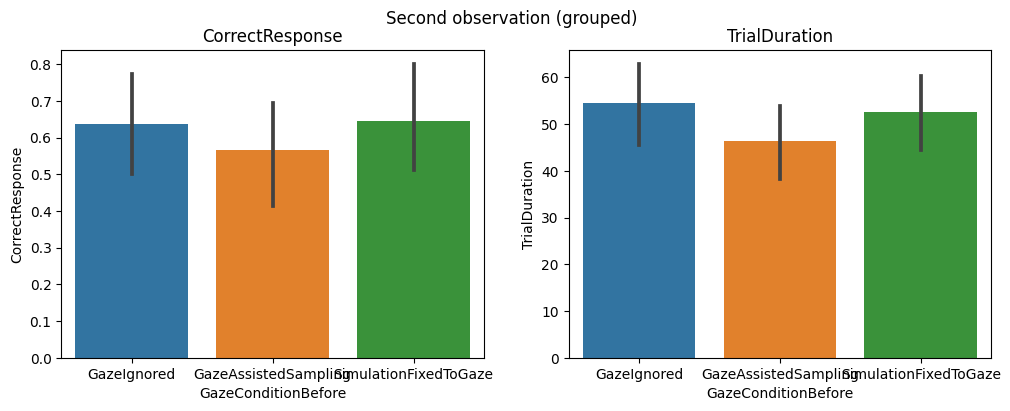

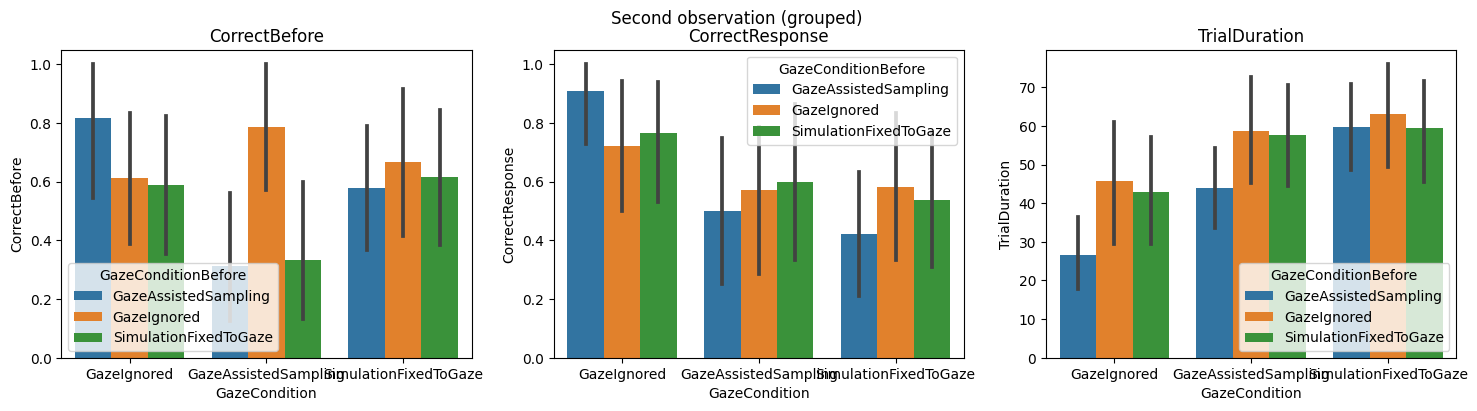

In [45]:
data['SeenBeforeCount'] = data.groupby(['Subject', 'EnvironmentName']).cumcount()
data['CorrectResponse'] = (data.EnvironmentClass == data.ReportedRoomCategory).astype(float)


reindexed = data.loc[SR_mask].set_index(['Subject','EnvironmentName'])
first_sight = reindexed.loc[reindexed['SeenBeforeCount'] == 0].copy()
second_sight = reindexed.loc[reindexed['SeenBeforeCount'] == 1].copy() #pun not intended
before = first_sight.loc[second_sight.index]


second_sight['GazeConditionBefore'] = before.GazeCondition
second_sight['SameConditionBefore'] = before.GazeCondition == second_sight.GazeCondition
second_sight['CorrectBefore'] = before.CorrectResponse

second_sight['CorrectImprovement'] = before.CorrectResponse



fig, axs = bar_plots(reindexed, ['CorrectResponse', 'TrialDuration'])
fig.suptitle('Overall response')

fig, axs = bar_plots(first_sight, ['CorrectResponse', 'TrialDuration'])
fig.suptitle('At first observation')

fig, axs = bar_plots(second_sight, ['CorrectResponse', 'TrialDuration'])
fig.suptitle('At second observation')

fig, axs = bar_plots(second_sight, ['CorrectResponse', 'TrialDuration'], x='GazeConditionBefore')
fig.suptitle('At second observation')


# fig, _ = bar_plots(second_sight, ['CorrectBefore', 'CorrectResponse', 'TrialDuration'], hue='GazeCondition', x='SameConditionBefore')
fig.suptitle('Second observation (grouped)')

fig, _ = bar_plots(second_sight, ['CorrectBefore', 'CorrectResponse', 'TrialDuration'], hue='GazeConditionBefore')
fig.suptitle('Second observation (grouped)')



#### Averaged for each subject / environment




All scene recognition trials


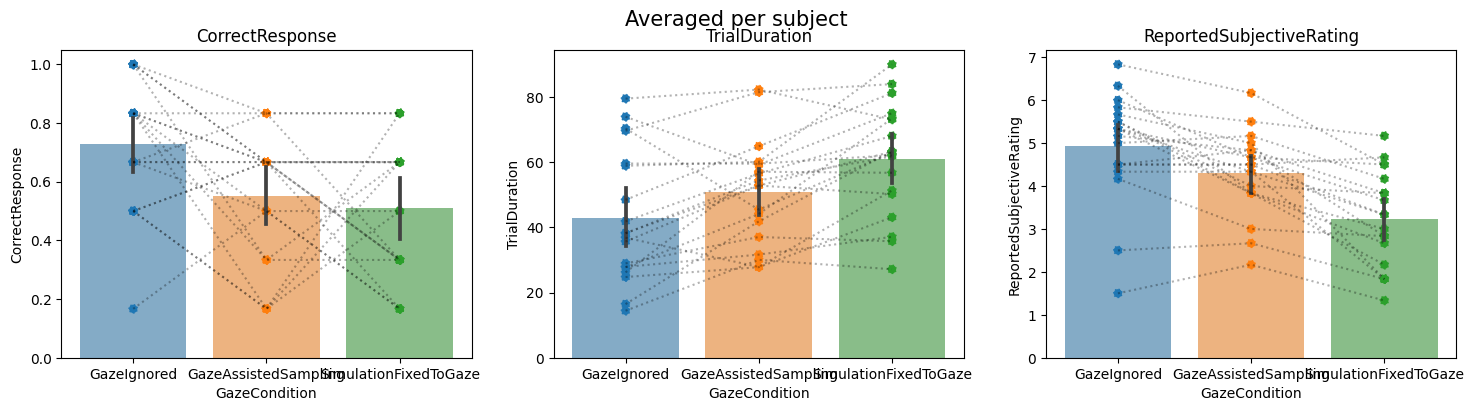




Scene recognition trials where scene is observed for the first time


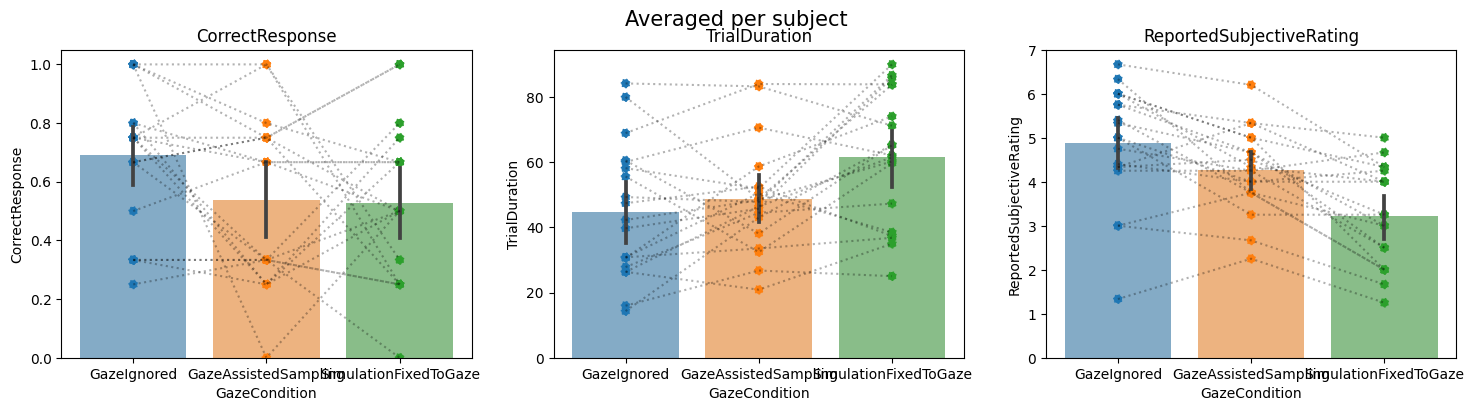




Scene recognition trials where scene is observed once before


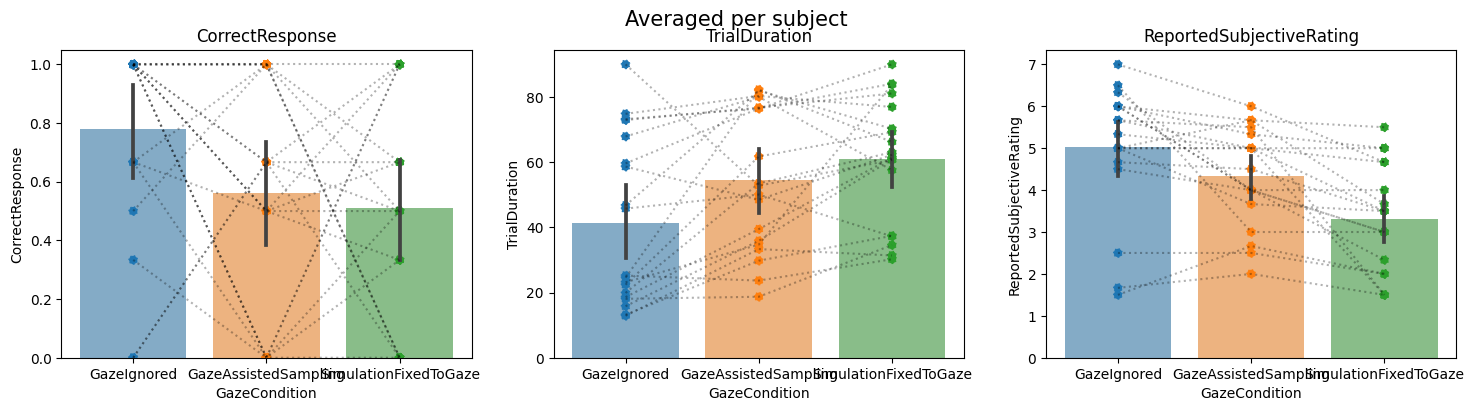

In [46]:
# GROUP = 'EnvironmentName'
GROUP = 'Subject'
endpoints = ['ReportedSubjectiveRating', 'TrialDuration', 'CorrectResponse']

def average(data, y, group='Subject', x='GazeCondition', apply_function=None):
    """Averages the endpoint variables <y> (list of column names) absover the grouping variable <group>."""
    avg = data.loc[:, [group,]+[x,] + y]
    if apply_function is None or apply_function=='mean':
        avg = avg.groupby([group, x]).mean()
    elif apply_function=='std':
        avg = avg.groupby([group, x]).std()
    else:
        avg = avg.groupby([group, x]).agg(apply_function)
    return avg.reset_index()

## Datasets
datasets = {'All scene recognition trials': data.loc[SR_mask],
            'Scene recognition trials where scene is observed for the first time': first_sight.reset_index(),
            'Scene recognition trials where scene is observed once before': second_sight.reset_index(),}


for descr, dataset in datasets.items():
    print('\n\n\n'+ descr)
    # Averaged for each subject
    avg = average(dataset, y=endpoints, group=GROUP)
    fig, axs = bar_plots(avg, ['CorrectResponse', 'TrialDuration', 'ReportedSubjectiveRating'], alpha=0.6)
    _, _ = swarm_plots(avg, ['CorrectResponse', 'TrialDuration', 'ReportedSubjectiveRating'], group=GROUP,axs=axs, jitter=0)
    fig.suptitle("Averaged per subject", fontsize=15)
    plt.show()

Text(0.5, 0.98, 'Visual search performance over time')

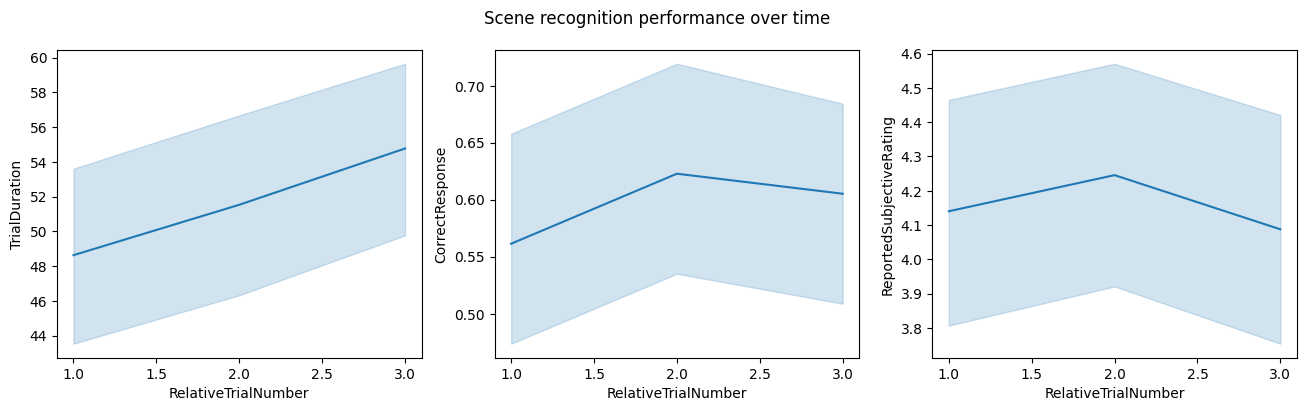

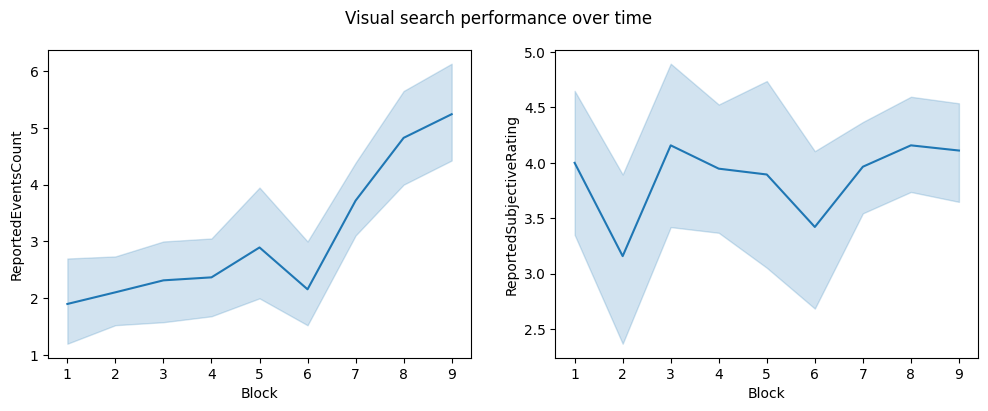

In [47]:
fig, axs = plt.subplots(1,3,figsize=(16,4))
sns.lineplot(data=data.loc[SR_mask], x='RelativeTrialNumber', y='TrialDuration', ax=axs[0])
sns.lineplot(data=data.loc[SR_mask], x='RelativeTrialNumber', y='CorrectResponse', ax=axs[1])
sns.lineplot(data=data.loc[SR_mask], x='RelativeTrialNumber', y='ReportedSubjectiveRating', ax=axs[2])
fig.suptitle("Scene recognition performance over time")

fig, axs = plt.subplots(1,2,figsize=(12,4))
sns.lineplot(data=data.loc[VS_mask], x='Block', y='ReportedEventsCount', ax=axs[0])
sns.lineplot(data=data.loc[VS_mask], x='Block', y='ReportedSubjectiveRating', ax=axs[1])
fig.suptitle("Visual search performance over time")

In [50]:
import sklearn
from sklearn.metrics import confusion_matrix

<AxesSubplot: >

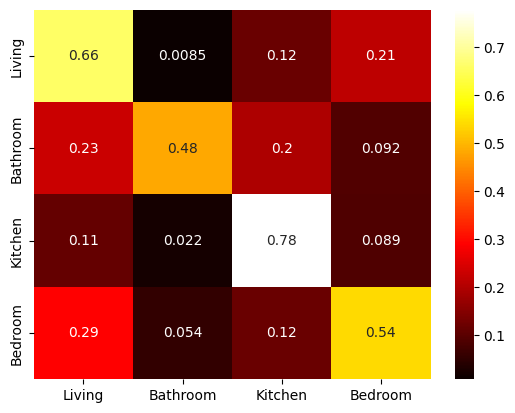

In [51]:
labels = ['Living', 'Bathroom', 'Kitchen', 'Bedroom']
conf = confusion_matrix(reindexed.EnvironmentClass,reindexed.ReportedRoomCategory, labels= labels)
total = conf.sum(axis=1)[:,np.newaxis].repeat(4, axis=1)
sns.heatmap(conf/total, annot=True, xticklabels=labels, yticklabels=labels, cmap='hot')

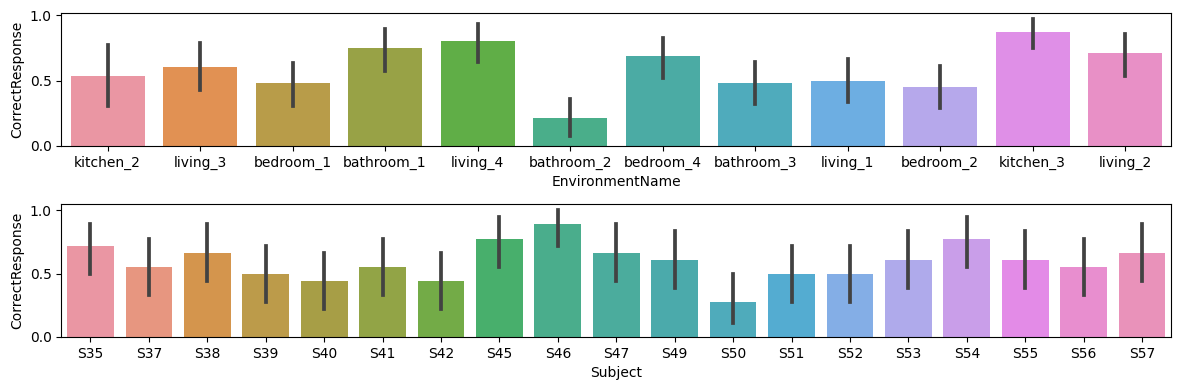

In [52]:
fig, axs = plt.subplots(2,1, figsize=(12,4), dpi=100)
sns.barplot(data=data.loc[SR_mask], x='EnvironmentName', y='CorrectResponse',ax= axs[0])
sns.barplot(data=data.loc[SR_mask].sort_values('Subject'), x='Subject', y='CorrectResponse',ax= axs[1])
plt.tight_layout()

## Engine data endpoints

##### Plotting functions

In [53]:
def violin_plots(data, endpoints):
    n_figs = len(endpoints)
    fig, axs = plt.subplots(1,n_figs,figsize=(6*n_figs,4), dpi=100)
    for i, y in enumerate(endpoints):
        sns.violinplot(data=data, x='GazeCondition', y=y, ax= axs[i])
        axs[i].set(title=y)
    return fig, axs

def bar_plots(data, endpoints, x='GazeCondition', **kwargs):
    n_figs = len(endpoints)
    fig, axs = plt.subplots(1,n_figs,figsize=(6*n_figs,4), dpi=100)
    for i, y in enumerate(endpoints):
        sns.barplot(data=data, x=x, y=y, ax= axs[i], **kwargs)
        axs[i].set(title=y)
    return fig, axs

##### Verify target hit

In [54]:
#### NOTE TO SELF: in some cases the visual search target appeared to have changed without updating the ReportedEventsCount! why?

In [55]:


# def plot_quiver_map(data, axs=None, color=None, fig=None):
#     if axs is None:
#         fig, axs = plt.subplots(1,2, figsize=(8,4), dpi=200,)
    
#     if color is None:
#         color = TARGETS.loc[data.ActiveTarget, 'Color'].to_list()
        
#         # Put targets in legend
#         targets = TARGETS.loc[data.ActiveTarget.unique(), 'Color'] # All targets that were observed in current data
#         print(targets)
#         handles = [Patch(facecolor=color[:3]+[1.0,], label=trg) for trg, color in targets.items()]
#         axs[0].legend(handles=handles)

    
#     # Head quiver (first axis)
#     x, y = data['XRHeadPosX'], data['XRHeadPosZ']
#     u, v = data['XRHeadDirX'], data['XRHeadDirZ']
#     axs[0].quiver(x,y,u,v, color=color, scale=15)
#     # axs[0].axis('square')
#     axs[0].set(title= 'Head')
    
#     # Hand Quiver
#     x, y = data['HandRPosX'], data['HandRPosZ']
#     u, v = data['HandRDirX'], data['HandRDirZ']
#     axs[1].quiver(x,y,u,v, color=color, scale=10)
#     # axs[1].axis('square')
#     axs[1].set(title= 'Right Hand')


#     return fig, axs

def plot_joint_plots(data, pairs, order=HUE_ORDER):
    
    # Create figure and Gridspec
    N = len(pairs)
    fig = plt.figure(figsize=(5*N, 4), dpi=200)
    gs = fig.add_gridspec(2, 3*N,  width_ratios=(4, 1, 1)*N, height_ratios=(1, 4),
                          left=0.1, right=0.9, bottom=0.1, top=0.9,
                          wspace=0.05, hspace=0.05)
    handles = []

    # Enumerate pairs and create each jointplot 
    for i, (x,y) in enumerate(pairs):
        
        # The scatterplot
        ax0 = fig.add_subplot(gs[1, 0 + 3*i])
        ax0.spines[['right', 'top']].set_visible(False)
#         sns.scatterplot(data=data, x=x, y=y, hue='GazeCondition',ax=ax0, legend=False, alpha=0.3)
    
        for condition in order: # ['GazeIgnored', 'GazeAssistedSampling', 'SimulationFixedToGaze']
            h = sns.regplot(data=data.loc[data.GazeCondition==condition],x=x,y=y, scatter_kws={'alpha':0.25})
            handles.append(h)

        # The distribution plots
        ax1 = fig.add_subplot(gs[0, 0 + 3*i], sharex=ax0)
        ax2 = fig.add_subplot(gs[1, 1 + 3*i], sharey=ax0)
        ax1.spines[['right', 'top', 'left']].set_visible(False)
        ax2.spines[['bottom', 'top', 'right']].set_visible(False)
        plt.setp(ax1.get_xticklabels() + ax2.get_yticklabels() + \
                [ax1.yaxis,  ax2.xaxis], visible=False)
        h1 = sns.kdeplot(data=data, x=x, hue='GazeCondition',ax=ax1, legend=False, fill=True)
        h2 = sns.kdeplot(data=data, y=y, hue='GazeCondition',ax=ax2, legend=False, fill=True)
        handles += [h1,h2,]
    return handles

def plot_targets(targets, ax):
    colors = get_colors(labels=targets.index, alpha=1.)
    color = pd.Series(colors).loc[targets.index].to_list()
    hdl = ax.scatter(targets.PosX, targets.PosZ, c = color)
    return

def get_colors(labels, cmap='viridis', alpha=0.25):
    colormap = matplotlib.colormaps.get_cmap(cmap)
    colors = colormap(np.linspace(0,1,len(labels)))
    colors[:,-1]=alpha
    return {lbl: colors[i].tolist() for i, lbl in enumerate(labels)}

def get_target_locations(filename ='_TargetLocations.tsv', sep='\t'):
    fn = os.path.join(DATA_DIR,filename)
    targets = pd.read_csv(fn, sep=sep).set_index('TargetName')
    return targets

def angle_between(a, b):
    """Calculate the shortest angle between two complex numbers (represented as vectors on the complex plane)
    return value in degrees"""
    theta = np.angle(a) - np.angle(b)
    theta *= 180/np.pi  #convert to degrees
    theta = (theta + 180) % 360 - 180 # find the shortest angle (e.g. -270 -> 90 deg.)
    return theta

def get_localization_errors(data, targets, columns=None):

    # Get event frames (out)
    event_occurred = data.groupby('TrialIdentifier').ReportedEventsCount.diff() > 0
    out = data.loc[event_occurred].copy()
    
    
    # Some data (e.g. search duration) are found in the final frame before the event
    final_frames = data.shift().loc[event_occurred]
    copy_from_final = ['ReportedEventsCount', 'SearchDuration']
    out[copy_from_final] = final_frames[copy_from_final]
    
    # Positions of the sensors (head and hand)
    out['HeadPosXZ'] = (out.XRHeadPosX + out.XRHeadPosZ*1j).values
    out['HandPosXZ'] = (out.HandRPosX + out.HandRPosZ*1j).values
    out['OrgPosXZ'] = (out.XROriginPosX + out.XROriginPosZ * 1j).values

    # Position of the targets
    out['TrgPosXZ'] = (targets.loc[out['ActiveTarget']].PosX + \
                       targets.loc[out['ActiveTarget']].PosZ * 1j).values

    # Pointing locations
    out['HandPntXZ'] = (out.PointLocationHandX + out.PointLocationHandZ*1j).values
    out['HeadPntXZ'] = (out.PointLocationHeadX + out.PointLocationHeadZ*1j).values
    out['EyePntXZ'] = (out.PointLocationEyeX + out.PointLocationEyeZ*1j).values
    
    # Raycasts from hand
    out['Hand2HandPnt'] = out.HandPntXZ - out.HandPosXZ # Raycast hit location (hand) w.r.t. hand pos
    out['Head2HandPnt'] = out.HandPntXZ - out.HeadPosXZ # Raycast hit location (hand) w.r.t. head pos
    
    # Raycasts from head and eyes
    out['Head2HeadPnt'] = out.HeadPntXZ - out.HeadPosXZ # Raycast hit location (head) w.r.t. head pos
    out['Head2EyePnt'] =  out.EyePntXZ - out.HeadPosXZ # Raycast hit location (eyes) w.r.t. head pos
    
    # Target positions
    out['Hand2Targ'] = out.TrgPosXZ - out.HandPosXZ # Target location w.r.t. hand pos
    out['Head2Targ'] = out.TrgPosXZ - out.HeadPosXZ # Target location w.r.t. head pos

    # Localization errors (angles with respect to vector from head to target)
    out['LocalizationErrorHand'] = angle_between(out.Head2HandPnt, out.Head2Targ)
    out['LocalizationErrorHead'] = angle_between(out.Head2HeadPnt, out.Head2Targ)
    out['LocalizationErrorEyes'] = angle_between(out.Head2EyePnt, out.Head2Targ)
    
    # Relative errors (mismatch)
    out['HeadHandMismatch'] = (out['LocalizationErrorHead'] - out['LocalizationErrorHand']  + 180) % 360 - 180
    out['EyeHandMismatch'] = (out['LocalizationErrorEyes'] - out['LocalizationErrorHand']  + 180) % 360 - 180
    out['HeadEyeMismatch'] = (out['LocalizationErrorHead'] - out['LocalizationErrorEyes']  + 180) % 360 - 180
    
    if columns is None:
        columns = ['ActiveTarget','Subject', 'Block', 'RelativeTrialNumber', 
                   'ExperimentalTask', 'GazeCondition','TotalReportedEvents',
                   'HeadPosXZ', 'HandPosXZ', 'OrgPosXZ', 'TrgPosXZ', 'HandPntXZ',
                   'HeadPntXZ', 'EyePntXZ',  'Hand2HandPnt', 'Head2HandPnt',
                   'Head2HeadPnt', 'Head2EyePnt', 'Hand2Targ', 'Head2Targ', 
                   'SearchDuration', 'LocalizationErrorHand',
                   'LocalizationErrorHead','LocalizationErrorEyes',
                   'HeadHandMismatch', 'EyeHandMismatch', 'HeadEyeMismatch']
    
    
    return out.set_index(['TrialIdentifier','ReportedEventsCount'])[columns]


# Load all targets
TARGETS = get_target_locations()
TARGETS['Color'] = get_colors(TARGETS.index).values()



In [56]:
# event_frames.columns['ActiveTarget','Subject', 'Block', 'RelativeTrialNumber', 
#                      'ExperimentalTask', 'GazeCondition','TotalReportedEvents',
#                      , 'HeadPosXZ', 'HandPosXZ', 'OrgPosXZ', 'TrgPosXZ', 'HandPntXZ',
#                      'HeadPntXZ', 'EyePntXZ', 'SearchDuration', 'LocalizationErrorHand',
#                      'LocalizationErrorHead','LocalizationErrorEyes']

In [90]:
## Which data to show
subjects = SUBJECTS # or specify list of subjects of interest

# TARGET_IDX = {trg:i for i, trg in enumerate(sorted(data.ActiveTarget.unique().tolist()))}

MAX_TIME = 200 # seconds. Search times that are higher are discarded
MIN_TIME = 1.2 # seconds. Search times that are lower are discarded
MAX_ANGLE = 10 # degrees (Error between hand pointing angle and actual target angle)


## Load the eye tracking data
data = EXP_DATA['EngineDataRecord'].copy()
data = data.loc[data.ExperimentalTask == 'VisualSearch'] # Only visual searhc
data = data.loc[data.Block>7] # Exclude practice block
data = data.loc[(data.Subject.isin(subjects))] # Specified subjects

# Useful grouping indices
trial_index= ['TrialIdentifier',]
targ_index = ['TrialIdentifier','ReportedEventsCount'] # To group by visual search instance (within a trial)
time_index = ['TrialIdentifier', 'TimeStamp'] # To index by timestamp (unique frame identifier)

# Total reported objects
total_reported = data.groupby(trial_index).ReportedEventsCount.max()
data['TotalReportedEvents'] = total_reported.loc[data.TrialIdentifier].values
data['ReportedAsFound'] = data.ReportedEventsCount < data.TotalReportedEvents

# Find and calculate the time between 'event triggers' reported by subject
start_trial = data.ne(data.shift()).TrialIdentifier # True for first frame of each trial
event_occurred = data.groupby(trial_index).ReportedEventsCount.diff() > 0 # True for frames where event count increases (trigger was pressed)
start_of_search = data.where(start_trial | event_occurred).TimeStamp.ffill()  # Timestamps for the start of search 
start_of_search.loc[data.ReportedEventsCount > 0] += 1e7 # Next visual search instances starts 1 second after the previous one ended
data['SearchDuration'] = (data.TimeStamp - start_of_search) * 1e-7


event_frames = get_localization_errors(data, targets=TARGETS)

# # # Extract each very last frame before the trigger was pressed.
# final_frame_timestamp = data.groupby(targ_index).TimeStamp.max()
# final_frame_mask = final_frame_timestamp.reset_index().set_index(time_index).index
# final_frames = data.set_index(time_index).loc[final_frame_mask].reset_index().set_index(targ_index)



# # Group by visual search instance, and calculate the maximum value
# trg_group_idx = ['TrialIdentifier','ReportedEventsCount', 'Subject', 'GazeCondition', 'ActiveTarget']
# grouped_by_target = data.groupby(trg_group_idx)
# search_times = grouped_by_target.SecondsSinceEvent.max().reset_index(trg_group_idx)
# search_times = search_times.loc[(search_times.SecondsSinceEvent<MAX_TIME) &
#                                 (search_times.SecondsSinceEvent>MIN_TIME)]

# trial_group_idx = ['TrialIdentifier', 'GazeCondition']
# grouped_by_trial = data.groupby(trial_group_idx)
# n_targets = grouped_by_target.ReportedEventsCount.max().reset_index(trial_group_idx)

<AxesSubplot: xlabel='GazeCondition', ylabel='SearchDuration'>

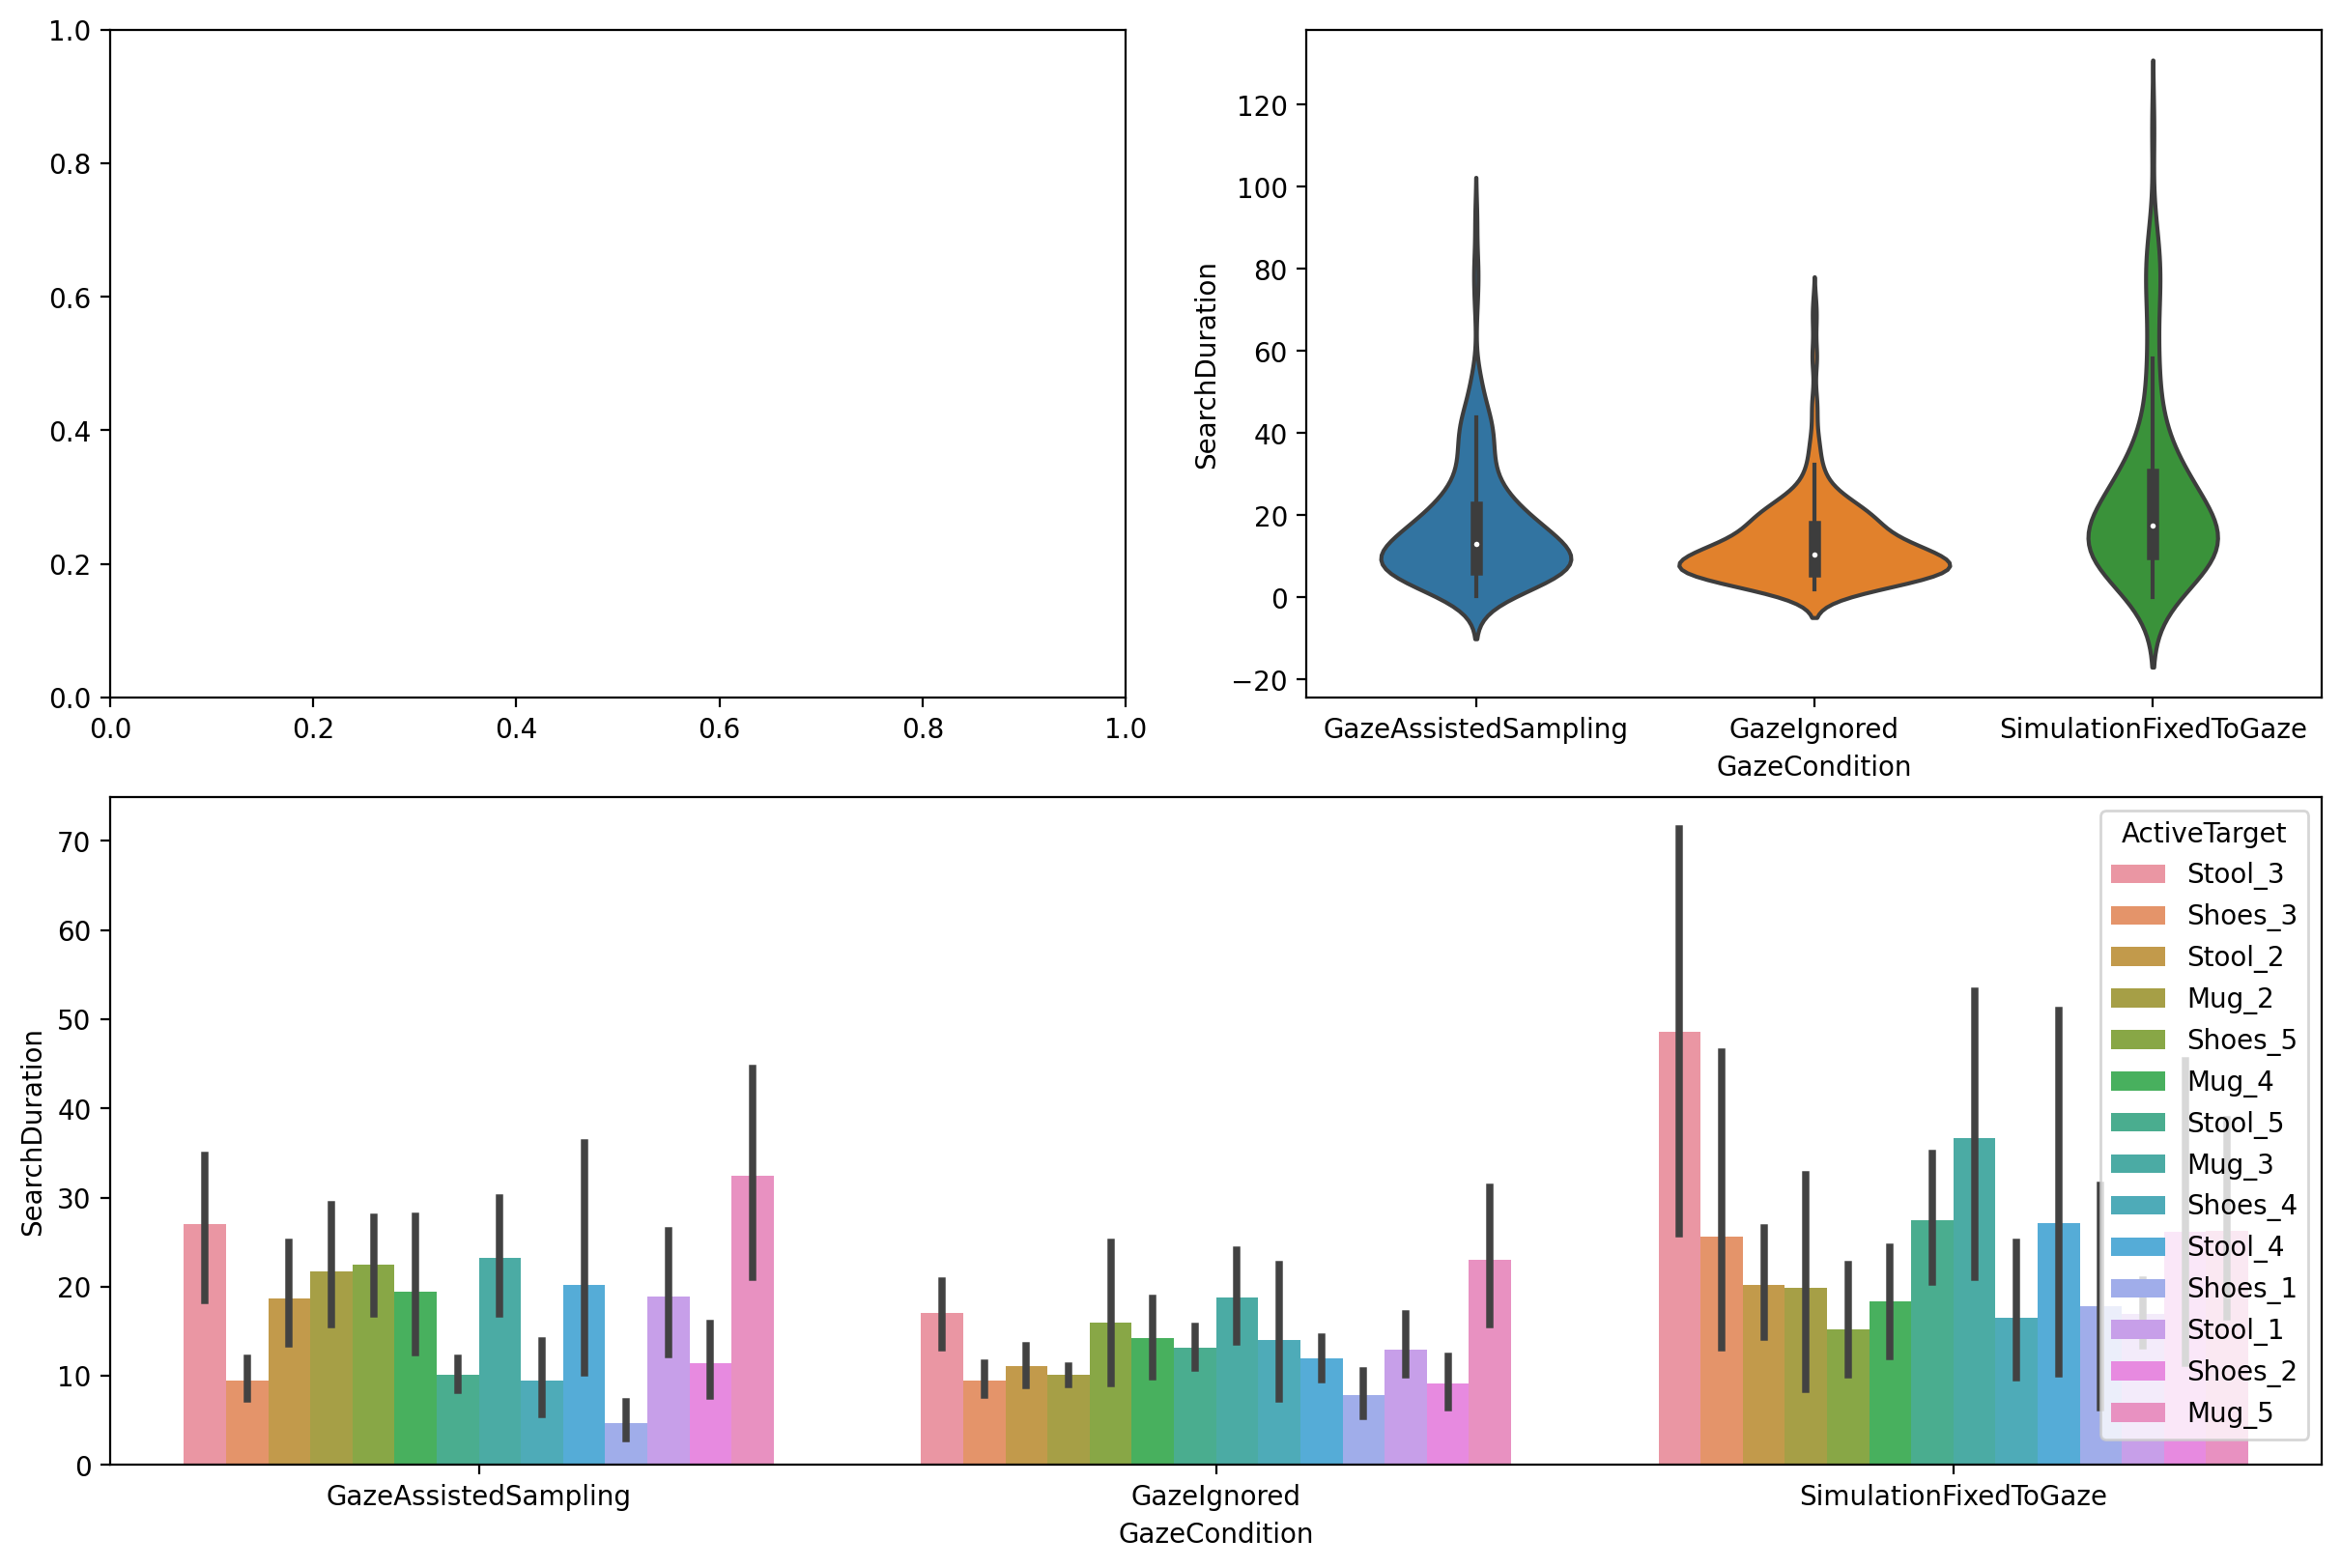

In [94]:
fig = plt.figure(figsize=(12, 8),dpi=200, layout="constrained")
spec = fig.add_gridspec(2, 2)
ax00 = fig.add_subplot(spec[0, 0])
ax01 = fig.add_subplot(spec[0, 1])
ax1 = fig.add_subplot(spec[1, :])

sns.barplot(data=event_frames, x='GazeCondition', y='SearchDuration', hue='ActiveTarget', ax=ax1)
sns.violinplot(data=event_frames, x='GazeCondition', y='SearchDuration', ax=ax01)
# sns.violinplot(data=event_frames, x='GazeCondition', y='ReportedEventsCount', ax=ax00)

In [58]:

# event_frames.groupby(['Subject', 'GazeCondition'])['LocalizationErrorHead', 'LocalizationErrorEyes', 'LocalizationErrorHead'].apply()

<AxesSubplot: xlabel='GazeCondition', ylabel='LocalizationErrorEyes'>

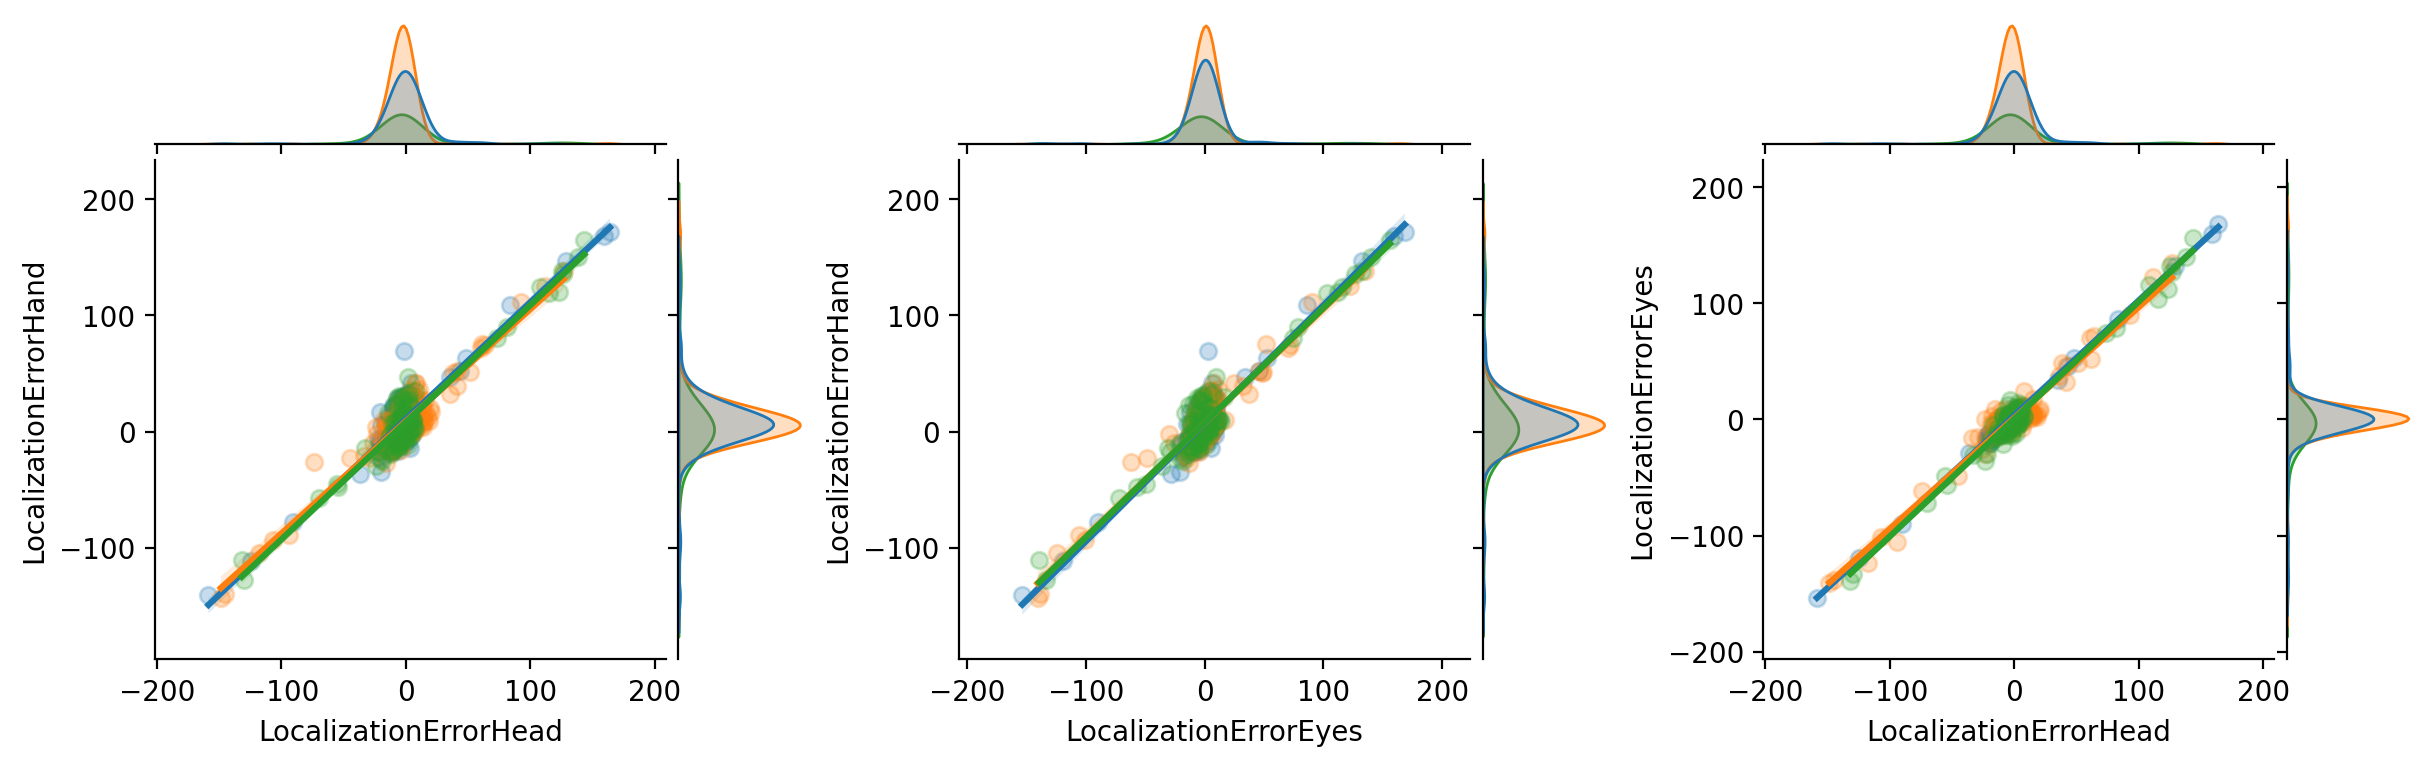

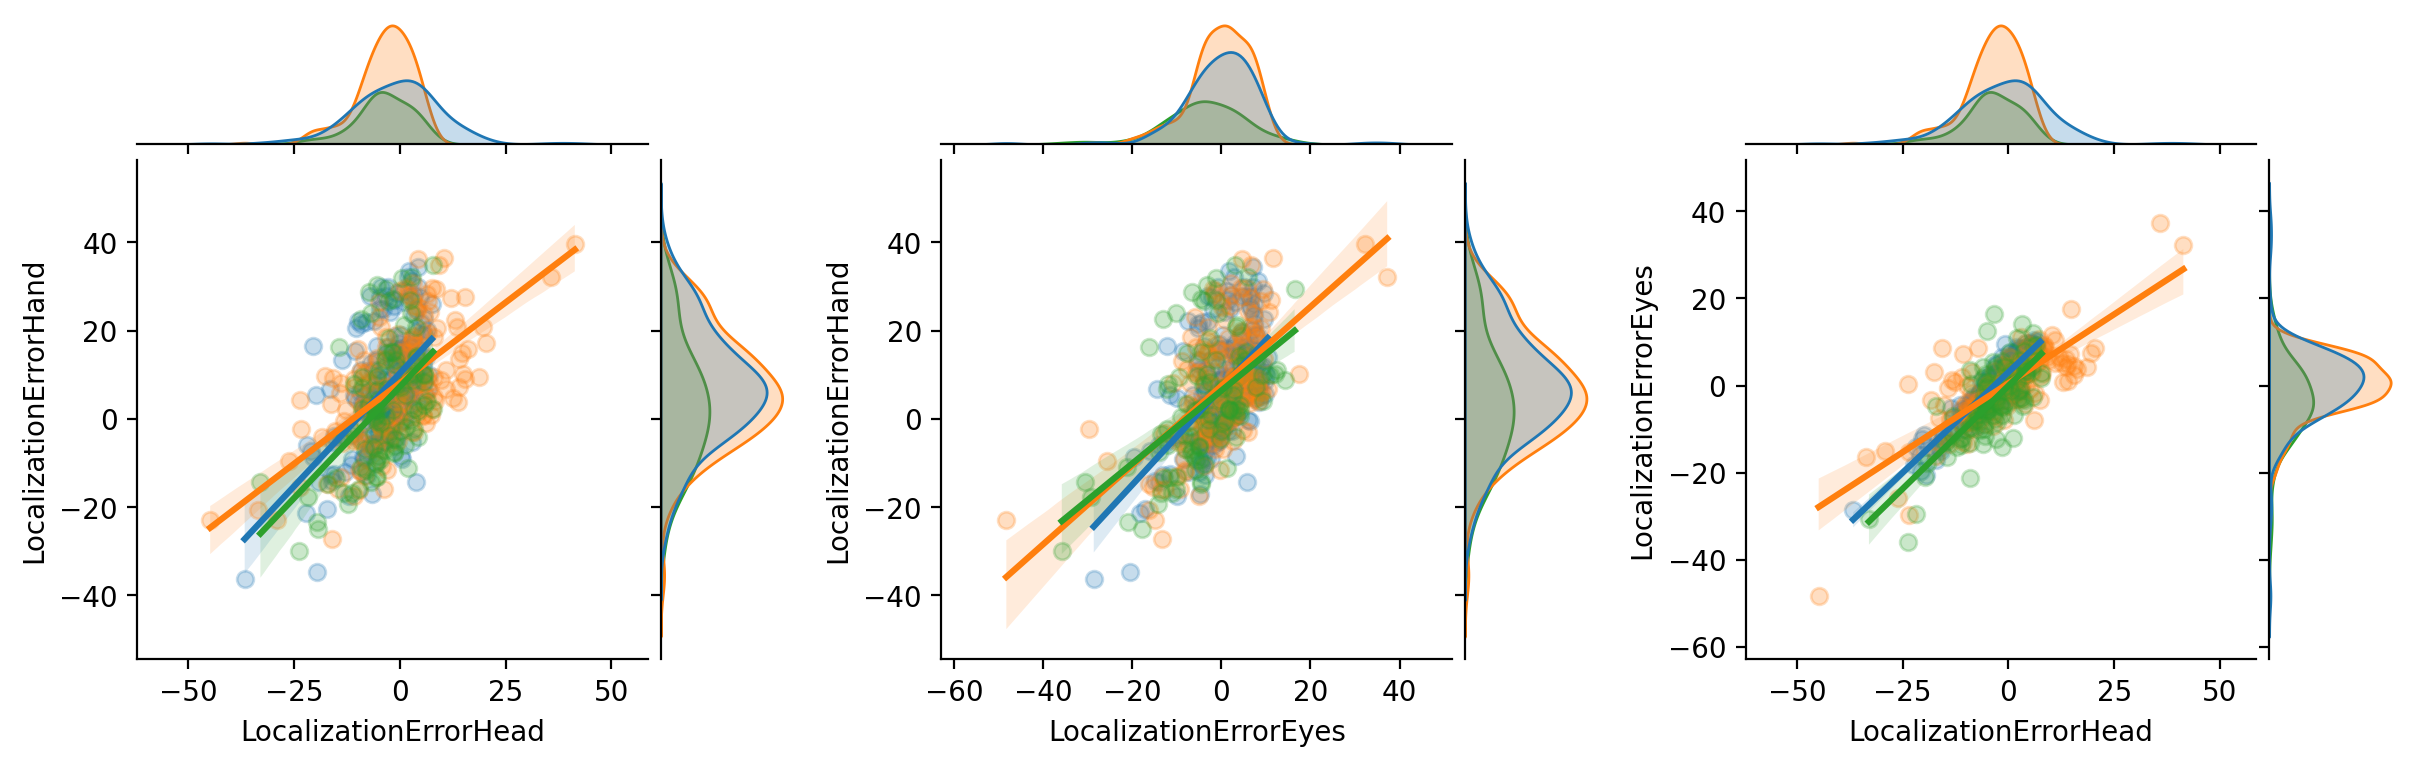

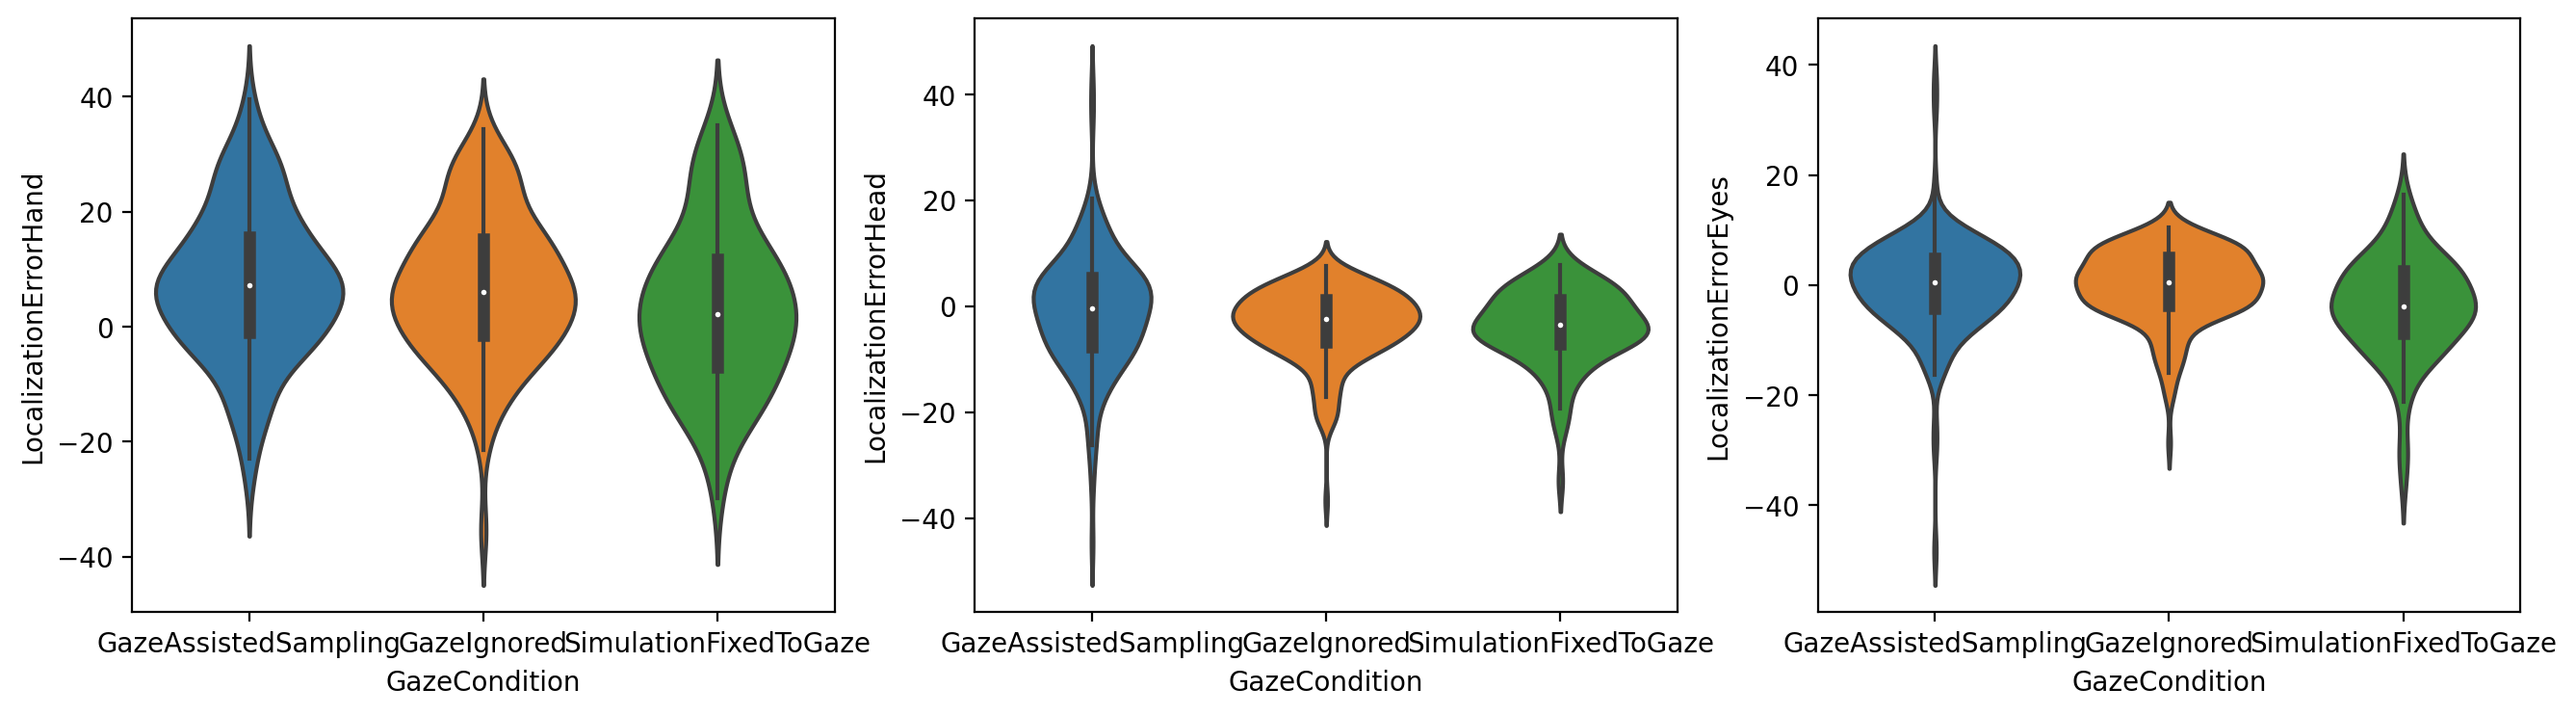

In [76]:
# fig, axs = plt.subplots(1,3, figsize=(16,4), dpi=200)
# sns.histplot(data=event_frames, x='LocalizationErrorHand', hue='GazeCondition', ax=axs[0], alpha=0.3)
# sns.histplot(data=event_frames, x='LocalizationErrorHead', hue='GazeCondition', ax=axs[1], alpha=0.3)
# sns.histplot(data=event_frames, x='LocalizationErrorEyes', hue='GazeCondition', ax=axs[2], alpha=0.3)

# fig, axs = plt.subplots(1,2, figsize=(12,4), dpi=200)
# sns.histplot(data=event_frames, x='HeadHandMismatch', hue='GazeCondition', ax=axs[0], alpha=0.3)
# sns.histplot(data=event_frames, x='EyeHandMismatch', hue='GazeCondition', ax=axs[1], alpha=0.3)


# Raycasts from hand
# x_axis = np.ones_like(event_frames.HandPntXZ)
# hand_ray = np.angle(event_frames.HandPntXZ - event_frames.HeadPosXZ) # Raycast hit location (hand) w.r.t. head pos
# head_ray =  np.angle(event_frames.HeadPntXZ - event_frames.HeadPosXZ) # Raycast hit location (head) w.r.t. head pos
# lo =  np.angle(event_frames.EyePntXZ - event_frames.HeadPosXZ) # Raycast hit location (eyes) w.r.t. head pos

# vec2angle = lambda x: angle_between(x,np.ones_like(x))
# conversions = {col: vec2angle for col in ['Head2HandPnt', 'Head2HeadPnt', 'Head2EyesPnt']}


# fig, axs = plt.subplots(1,3, figsize=(16,4), dpi=200)
# sns.scatterplot(data=event_frames.apply(conversions), x='Head2HandPnt', y='Head2HeadPnt', hue='GazeCondition', ax=axs[0], alpha=0.3)
# sns.scatterplot(data=event_frames, x=pointing_dir_, y=looking_dir_, hue='GazeCondition', ax=axs[1], alpha=0.3)
# sns.scatterplot(data=event_frames, x=looking_dir_, y=looking_dir, hue='GazeCondition', ax=axs[2], alpha=0.3)
                              
# fig, axs = plt.subplots(1,3, figsize=(16,4), dpi=200)
# sns.jointplot(data=event_frames, x='LocalizationErrorHand', y='LocalizationErrorHead', hue='GazeCondition',)# ax=axs[0], alpha=0.3)
# sns.jointplot(data=event_frames, x='LocalizationErrorHand', y='LocalizationErrorEyes', hue='GazeCondition',)# ax=axs[1], alpha=0.3)
# sns.jointplot(data=event_frames, x='LocalizationErrorHead', y='LocalizationErrorEyes', hue='GazeCondition',)# ax=axs[2], alpha=0.3)

pairs = [('LocalizationErrorHead', 'LocalizationErrorHand'), 
        ('LocalizationErrorEyes', 'LocalizationErrorHand'),
        ('LocalizationErrorHead', 'LocalizationErrorEyes')]
    
handles = plot_joint_plots(event_frames, pairs)

## CLEAN DATA
invalid = [False,] * len(event_frames)

# Remove target misses (hand is pointing very different from head, or hand is pointing completely wrong direction)
MISMATCH_BOUNDARY = 40
LOCALIZATION_BOUNDARY = 40
invalid = invalid | (np.abs(event_frames.HeadHandMismatch) > MISMATCH_BOUNDARY)
invalid = invalid | (np.abs(event_frames.LocalizationErrorHand) > LOCALIZATION_BOUNDARY)

# # Remove bad-performing subjects / difficult targets 
# STD_MAXIMUM_SUBJ = 15
# STD_MAXIMUM_TARG = 15

# std_subject = event_frames.groupby('Subject')[['LocalizationErrorHand', 'LocalizationErrorHead','LocalizationErrorEyes']].std()
# std_target = event_frames.groupby('ActiveTarget')[['LocalizationErrorHand', 'LocalizationErrorHead','LocalizationErrorEyes']].std()
# invalid_subjects = std_subject.loc[std_subject.LocalizationErrorHand > 40].index
# invalid_targets = std_target.loc[std_target.LocalizationErrorHand > 40].index
# invalid = invalid | event_frames.Subject.isin(invalid_subjects)
# invalid = invalid | event_frames.ActiveTarget.isin(invalid_targets)

# Exclude subjects with insufficient performance across all conditions
MINIMAL_TARGETS = 2 # minimal number of targets in each condition
n_targets_per_cond = event_frames.groupby(['Subject','GazeCondition']).ActiveTarget.count().unstack(fill_value=0)
exclude_subject = n_targets_per_cond.loc[(n_targets_per_cond < MINIMAL_TARGETS).any(axis=1)].index
invalid = invalid | event_frames.Subject.isin(exclude_subject)





plot_joint_plots(event_frames.loc[~invalid], pairs)


fig, axs = plt.subplots(1,3, figsize=(16,4), dpi=200)
sns.violinplot(data=event_frames.loc[~invalid], y='LocalizationErrorHand', x='GazeCondition', ax=axs[0])
sns.violinplot(data=event_frames.loc[~invalid], y='LocalizationErrorHead', x='GazeCondition', ax=axs[1])
sns.violinplot(data=event_frames.loc[~invalid], y='LocalizationErrorEyes', x='GazeCondition', ax=axs[2])

([], [])

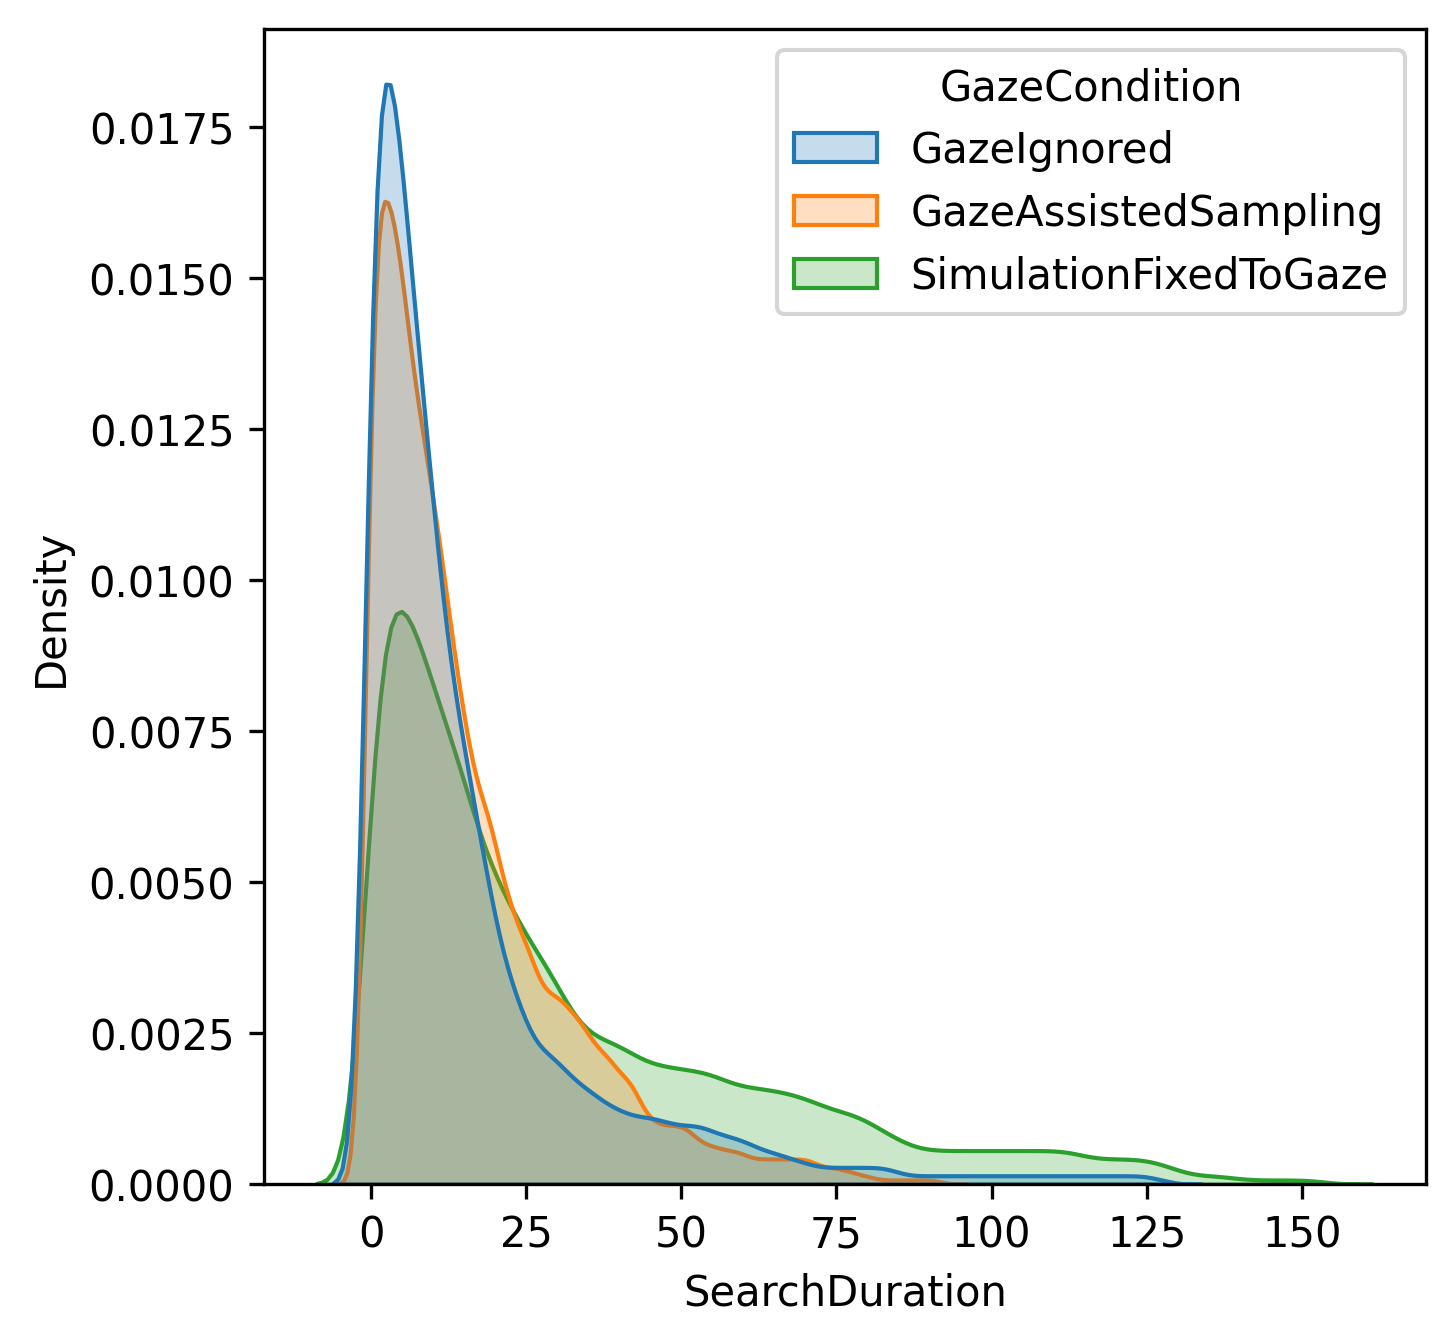

In [77]:
plt.figure(figsize=(5,5),dpi=300)
h = sns.kdeplot(data=data, x='SearchDuration', hue='GazeCondition', fill=True, hue_order=HUE_ORDER)
h.get_legend_handles_labels()

#### Absolute error, averaged per subject

In [78]:
def mean_absolute_error(data, endpoints, x='GazeCondition', group='Subject'):
    group_index = [x, group]
    absolute_error = data.set_index(group_index)[y].abs().reset_index()
    return average(absolute_error, y=y, x=x, group=group)

Text(0.5, 0.98, 'Absolute localization errors')

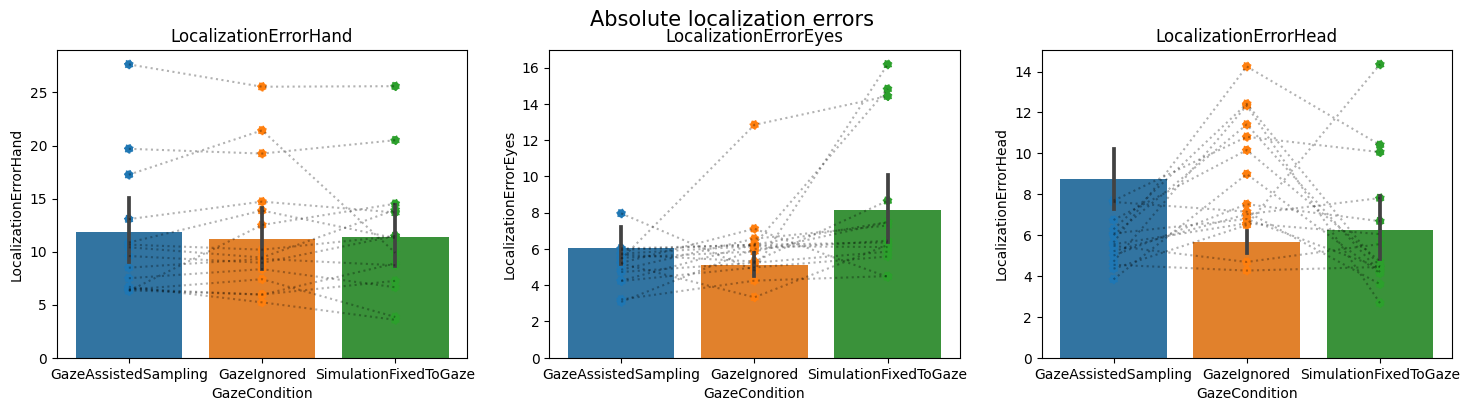

In [79]:
show = event_frames.loc[~invalid] # event_frames  or  event_frames.loc[~invalid]


# Absolute error averaged per subject
y = ['LocalizationErrorHand', 'LocalizationErrorEyes', 'LocalizationErrorHead']  
mae = mean_absolute_error(show, y)


fig, axs = bar_plots(mae, y)
_, _ = swarm_plots(mae, y, group='Subject',axs=axs, jitter=0)
fig.suptitle("Absolute localization errors", fontsize=15)

In [80]:
absolute_error.groupby(['Subject', 'GazeCondition']).mean().reset_index()

NameError: name 'absolute_error' is not defined

<AxesSubplot: xlabel='ActiveTarget', ylabel='LocalizationErrorEyes'>

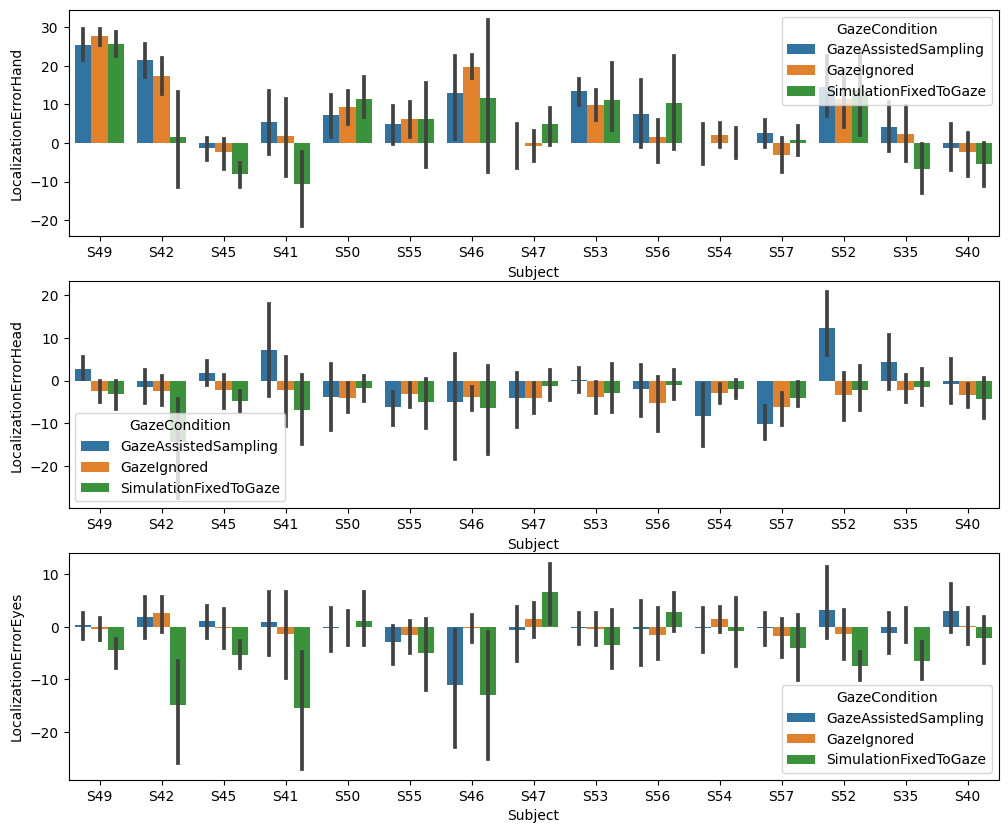

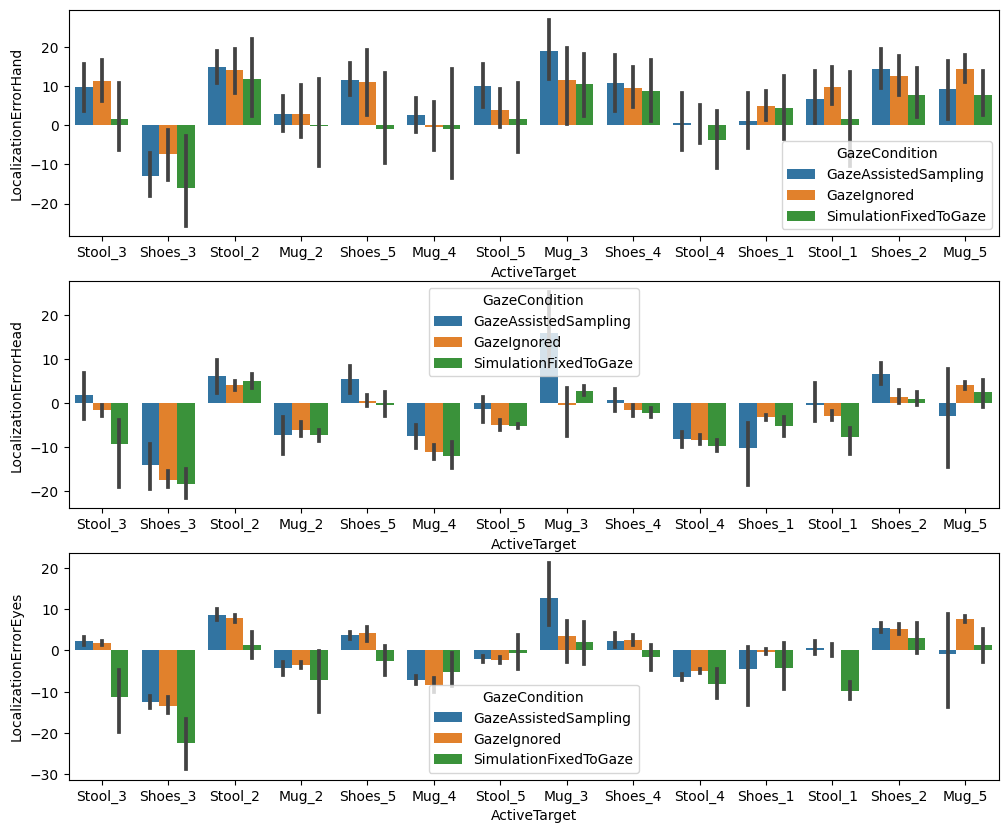

In [81]:
show = event_frames.loc[~invalid] # event_frames  or  event_frames.loc[~invalid]

fig, axs = plt.subplots(3,1,figsize=(12,10),dpi=100)
sns.barplot(data=show, y='LocalizationErrorHand', x='Subject', hue='GazeCondition', ax=axs[0])
sns.barplot(data=show, y='LocalizationErrorHead', x='Subject', hue='GazeCondition', ax=axs[1])
sns.barplot(data=show, y='LocalizationErrorEyes', x='Subject', hue='GazeCondition', ax=axs[2])

fig, axs = plt.subplots(3,1,figsize=(12,10),dpi=100)
sns.barplot(data=show, y='LocalizationErrorHand', x='ActiveTarget', hue='GazeCondition', ax=axs[0])
sns.barplot(data=show, y='LocalizationErrorHead', x='ActiveTarget', hue='GazeCondition', ax=axs[1])
sns.barplot(data=show, y='LocalizationErrorEyes', x='ActiveTarget', hue='GazeCondition', ax=axs[2])

<AxesSubplot: xlabel='Subject', ylabel='LocalizationErrorEyes'>

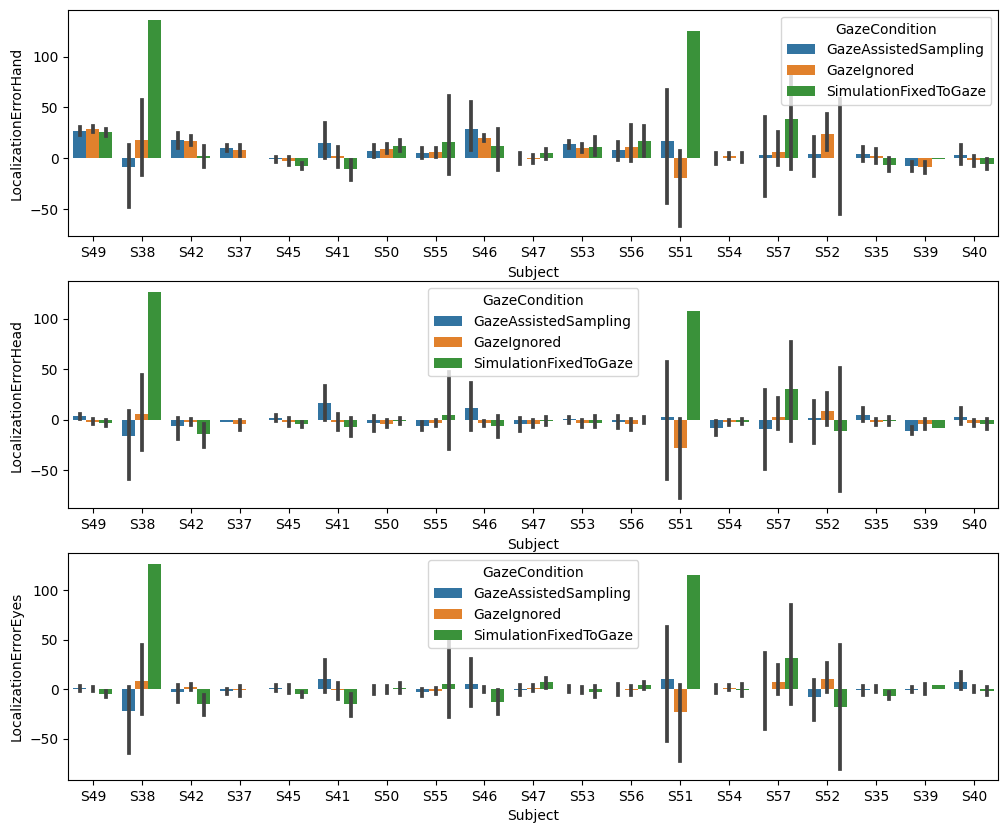

In [82]:
fig, axs = plt.subplots(3,1,figsize=(12,10),dpi=100)
sns.barplot(data=event_frames, y='LocalizationErrorHand', x='Subject', hue='GazeCondition', ax=axs[0])
sns.barplot(data=event_frames, y='LocalizationErrorHead', x='Subject', hue='GazeCondition', ax=axs[1])
sns.barplot(data=event_frames, y='LocalizationErrorEyes', x='Subject', hue='GazeCondition', ax=axs[2])

<AxesSubplot: xlabel='ActiveTarget', ylabel='LocalizationErrorEyes'>

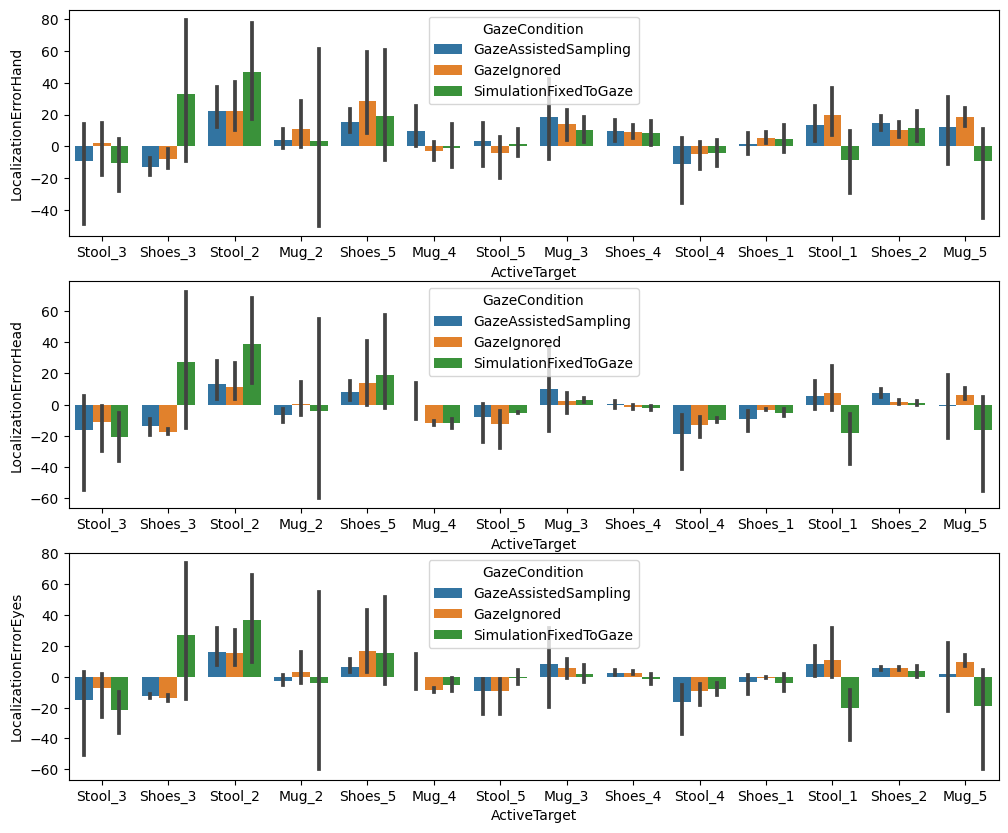

In [83]:
fig, axs = plt.subplots(3,1,figsize=(12,10),dpi=100)
sns.barplot(data=event_frames, y='LocalizationErrorHand', x='ActiveTarget', hue='GazeCondition', ax=axs[0])
sns.barplot(data=event_frames, y='LocalizationErrorHead', x='ActiveTarget', hue='GazeCondition', ax=axs[1])
sns.barplot(data=event_frames, y='LocalizationErrorEyes', x='ActiveTarget', hue='GazeCondition', ax=axs[2])

##### Old code for plotting localization errors

In [69]:
# Load all targets
TARGETS = get_target_locations()
TARGETS['Color'] = get_colors(TARGETS.index).values()

# specify targets of interest 
targets = TARGETS 

# event_frames = final_frames

# Positions and orientations of the sensors (head and hand)
head_pos = (event_frames.XRHeadPosX + event_frames.XRHeadPosZ*1j).values
head_dir = (event_frames.XRHeadDirX + event_frames.XRHeadDirZ*1j).values
hand_pos = (event_frames.HandRPosX + event_frames.HandRPosZ*1j).values
hand_dir = (event_frames.HandRDirX + event_frames.HandRDirZ*1j).values
org_pos = (event_frames.XROriginPosX + event_frames.XROriginPosZ * 1j).values
org_dir = (event_frames.XROriginDirX + event_frames.XROriginDirZ * 1j).values

# Position of the targets
trg_pos = (targets.loc[event_frames['ActiveTarget']].PosX + \
           targets.loc[event_frames['ActiveTarget']].PosZ * 1j).values

# Pointing locations
hand_point = (event_frames.PointLocationHandX + event_frames.PointLocationHandZ*1j).values
head_point = (event_frames.PointLocationHeadX + event_frames.PointLocationHeadZ*1j).values
eyes_point = (event_frames.PointLocationEyeX + event_frames.PointLocationEyeZ*1j).values

# 
event_frames['LocalizationErrorHand'] = angle_between(hand_point-hand_pos, trg_pos-hand_pos)
event_frames['LocalizationErrorHead'] = angle_between(head_point-head_pos, trg_pos-head_pos)
event_frames['LocalizationErrorEyes'] = angle_between(eyes_point-head_pos, trg_pos-head_pos)

# invalid = event_frames[event_frames.SecondsSinceEvent > MAX_TIME].index
# invalid = event_frames.append(last_frames[event_frames.SecondsSinceEvent < MIN_TIME].index)
# invalid = event_frames.append()

AttributeError: 'DataFrame' object has no attribute 'XRHeadPosX'

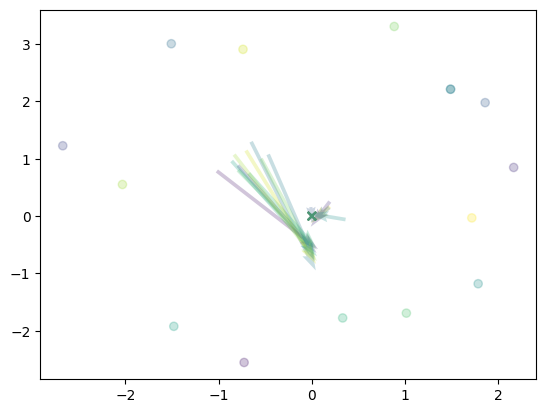

In [352]:
targets = TARGETS

hits = event_frames[:15]
colors = targets.loc[hits.ActiveTarget,'Color']
plt.quiver(hits.HandRPosX, hits.HandRPosZ, hits.PointLocationHandX-hits.HandRPosX, hits.PointLocationHandZ-hits.HandRPosZ, scale=5, color=colors)
plt.scatter(targets.loc[hits['ActiveTarget']].PosX, targets.loc[hits['ActiveTarget']].PosZ, c=colors)
plt.scatter( hits.PointLocationHandX, hits.PointLocationHandZ,marker='x', c=colors, )
# axs[2].scatter(np.real(eyes_point), np.imag(eyes_point),marker='+', c=colors, )
# axs[2].scatter(np.real(head_point), np.imag(head_point),marker='^', c=colors, )

In [86]:
## Remove invalid targets

# Criteria
MAX_TIME = 200 # seconds. Search times that are higher are discarded
MIN_TIME = .5 # seconds. Search times that are lower are discarded

# Add time since last event as new column
event_mask = data.groupby('TrialIdentifier').ReportedEventsCount.diff() !=0
data['SecondsSinceEvent'] = (data.TimeStamp - data.where(event_mask).TimeStamp.ffill()) * 1e-7

# Search duration is max time since last event when grouped by target
targ_idx = ['TrialIdentifier','ReportedEventsCount']
search_durations = data.groupby(targ_idx).SecondsSinceEvent.max()

# Find the invalid search instances
invalid = search_durations.loc[search_durations>200].index

# Keep dataframe with valid search instances (indexed by instance: i.e. 1 target)
reindexed = data.set_index(targ_idx)
reindexed = reindexed.drop(invalid)

# Reset index to original format
valid = reindexed.reset_index(targ_idx)
valid['ValidEvent'] = valid.groupby('TrialIdentifier').ReportedEventsCount.diff() > 0
valid['ValidEventCount'] = valid.groupby('TrialIdentifier').ValidEvent.cumcount()

## Target reports

In [87]:
def plot_quiver_map(data, axs=None, color=None, fig=None):
    if axs is None:
        fig, axs = plt.subplots(1,2, figsize=(8,4), dpi=200,)
    
    if color is None:
        color = TARGETS.loc[data.ActiveTarget, 'Color'].to_list()
        
        # Put targets in legend
        targets = TARGETS.loc[data.ActiveTarget.unique(), 'Color'] # All targets that were observed in current data
        print(targets)
        handles = [Patch(facecolor=color[:3]+[1.0,], label=trg) for trg, color in targets.items()]
        axs[0].legend(handles=handles)

    
    # Head quiver (first axis)
    x, y = data['XRHeadPosX'], data['XRHeadPosZ']
    u, v = data['XRHeadDirX'], data['XRHeadDirZ']
    axs[0].quiver(x,y,u,v, color=color, scale=15)
    # axs[0].axis('square')
    axs[0].set(title= 'Head')
    
    # Hand Quiver
    x, y = data['HandRPosX'], data['HandRPosZ']
    u, v = data['HandRDirX'], data['HandRDirZ']
    axs[1].quiver(x,y,u,v, color=color, scale=10)
    # axs[1].axis('square')
    axs[1].set(title= 'Right Hand')


    return fig, axs

def plot_targets(targets, ax):
    colors = get_colors(labels=targets.index, alpha=1.)
    color = pd.Series(colors).loc[targets.index].to_list()
    hdl = ax.scatter(targets.PosX, targets.PosZ, c = color)
    return

def get_colors(labels, cmap='viridis', alpha=0.25):
    colormap = matplotlib.colormaps.get_cmap(cmap)
    colors = colormap(np.linspace(0,1,len(labels)))
    colors[:,-1]=alpha
    return {lbl: colors[i].tolist() for i, lbl in enumerate(labels)}

def get_target_locations(filename ='_TargetLocations.tsv', sep='\t'):
    fn = os.path.join(DATA_DIR,filename)
    targets = pd.read_csv(fn, sep=sep).set_index('TargetName')
    return targets


TARGETS = get_target_locations()
TARGETS['Color'] = get_colors(TARGETS.index).values()

In [88]:
nEvents = valid.groupby('TrialIdentifier').ReportedEventsCount.max()
nEvents.sort_values()

TrialIdentifier
S41B7T0     0
S39B7T0     0
S39B4T0     0
S46B2T0     0
S38B9T1     0
           ..
S48B9T2    10
S40B8T0    11
S46B9T1    12
S46B8T1    12
S45B9T1    14
Name: ReportedEventsCount, Length: 162, dtype: int64

In [89]:
valid.columns

Index(['TrialIdentifier', 'ReportedEventsCount', 'TimeStamp', 'XROriginPos',
       'XROriginRot', 'XRHeadPos', 'XRHeadRot', 'HandLPos', 'HandLRot',
       'HandRPos', 'HandRRot', 'CollisionCount', 'FrameCount', 'ActiveTarget',
       'PointLocationHand', 'PointLocationEye', 'PointLocationHead',
       'TargetHit', 'Unnamed: 17', 'Subject', 'Block', 'RelativeTrialNumber',
       'ExperimentalTask', 'GazeCondition', 'XROriginDir', 'XRHeadDir',
       'HandLDir', 'HandRDir', 'XROriginPosX', 'XROriginPosY', 'XROriginPosZ',
       'XROriginRotW', 'XROriginRotX', 'XROriginRotY', 'XROriginRotZ',
       'XRHeadPosX', 'XRHeadPosY', 'XRHeadPosZ', 'XRHeadRotW', 'XRHeadRotX',
       'XRHeadRotY', 'XRHeadRotZ', 'HandLPosX', 'HandLPosY', 'HandLPosZ',
       'HandLRotW', 'HandLRotX', 'HandLRotY', 'HandLRotZ', 'HandRPosX',
       'HandRPosY', 'HandRPosZ', 'HandRRotW', 'HandRRotX', 'HandRRotY',
       'HandRRotZ', 'PointLocationHandX', 'PointLocationHandY',
       'PointLocationHandZ', 'PointLocationE

TargetName
Shoes_2    [0.449368, 0.813768, 0.335384, 0.25]
Stool_5      [0.175707, 0.6979, 0.491033, 0.25]
Mug_3      [0.275191, 0.194905, 0.496005, 0.25]
Shoes_4    [0.814576, 0.883393, 0.110347, 0.25]
Stool_4    [0.122312, 0.633153, 0.530398, 0.25]
Shoes_1    [0.288921, 0.758394, 0.428426, 0.25]
Stool_1    [0.180629, 0.429975, 0.557282, 0.25]
Mug_5       [0.212395, 0.359683, 0.55171, 0.25]
Stool_3    [0.127568, 0.566949, 0.550556, 0.25]
Shoes_3    [0.626579, 0.854645, 0.223353, 0.25]
Stool_2       [0.153364, 0.497, 0.557724, 0.25]
Name: Color, dtype: object


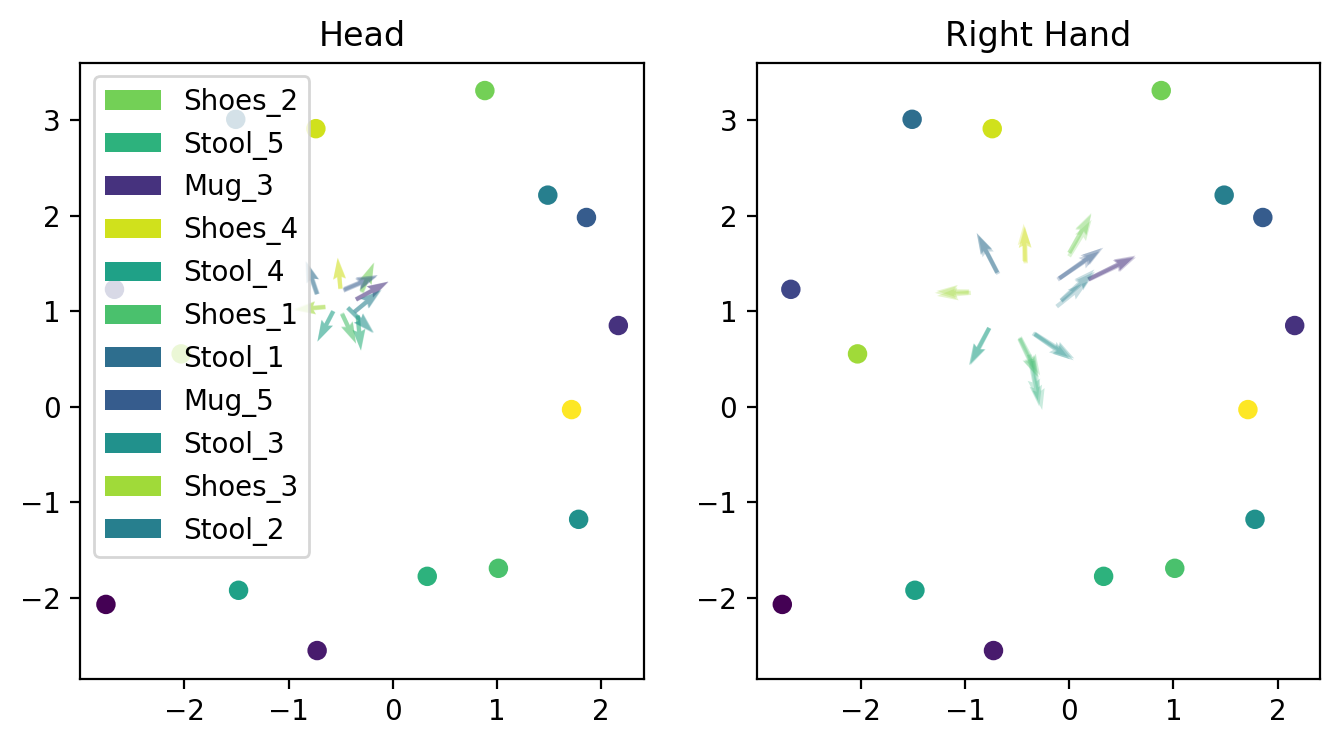

In [90]:
WINDOW = .5

targets = get_target_locations()

event_window_mask = (valid.SecondsSinceEvent < WINDOW) & (valid.ReportedEventsCount>0)
trial_mask = valid.TrialIdentifier == 'S40B8T0' # valid.TrialIdentifier.unique()[9]


# fig, axs = plot_quiver_map(valid.loc[trial_mask], targets=targets)
# fig, axs = plot_quiver_map(valid.loc[event_window_mask & trial_mask], color='red', axs=axs)

fig, axs = plot_quiver_map(valid.loc[event_window_mask & trial_mask])

plot_targets(targets, ax = axs[0])
plot_targets(targets, ax = axs[1])
# axs[0].plot(target_locations['PosX'], target_locations['PosZ'], '.')
plt.show(fig)

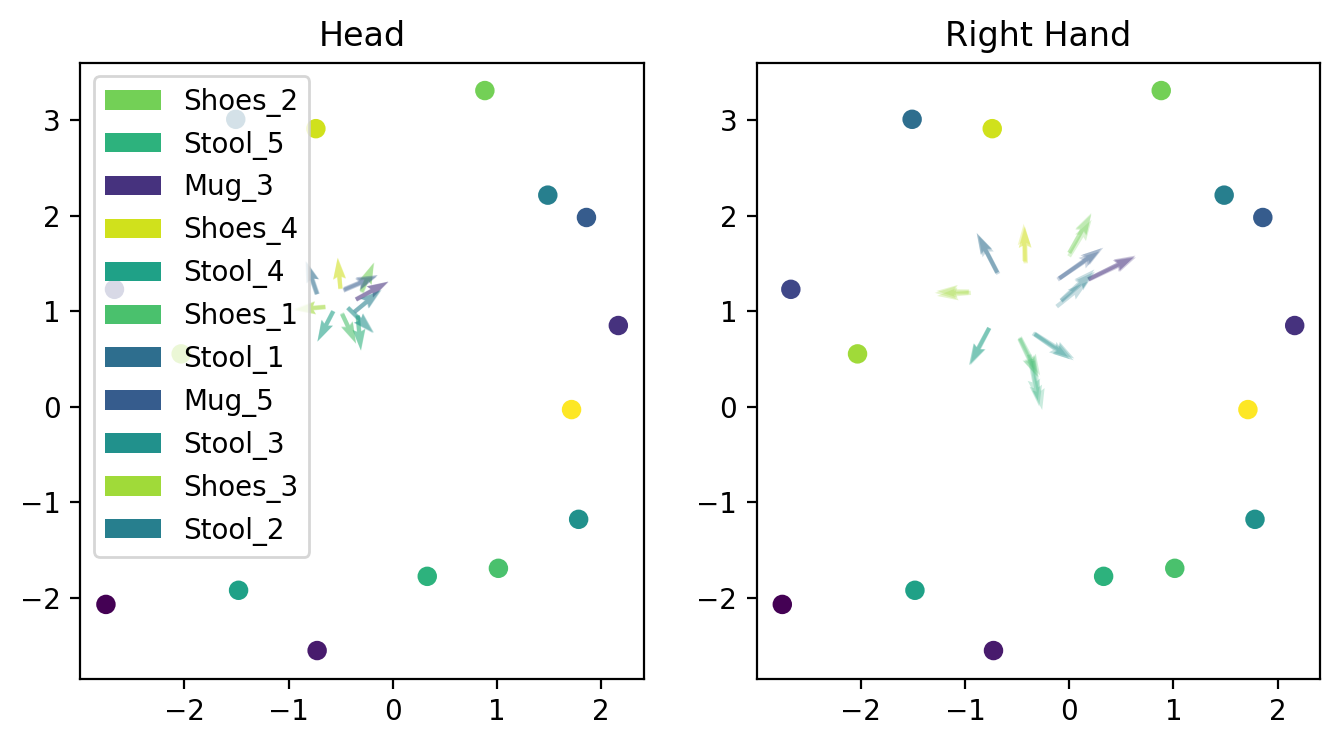

In [91]:
fig

In [54]:
hits = valid.loc[event_window_mask & trial_mask]
# hits = hits[:15].copy()

NameError: name 'd' is not defined

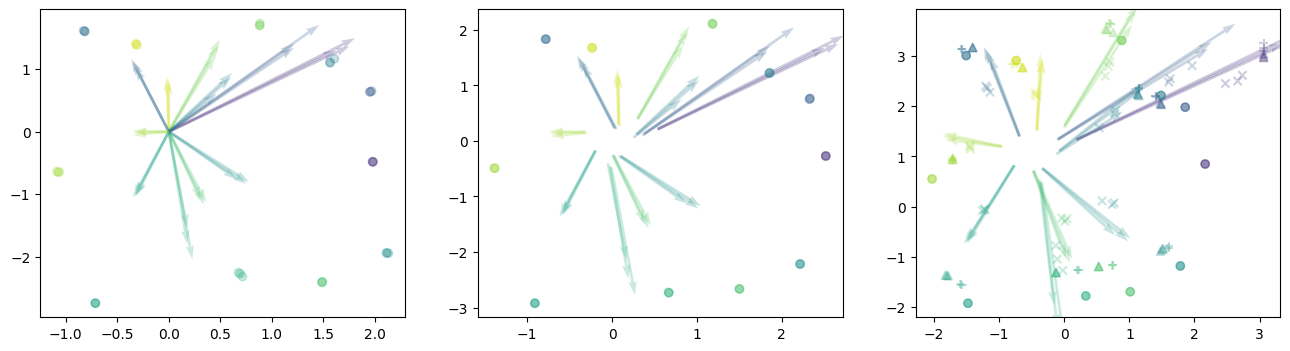

In [70]:
colors = TARGETS.loc[hits.ActiveTarget,'Color']

head_pos = (hits.XRHeadPosX + hits.XRHeadPosZ*1j).values
head_dir = (hits.XRHeadDirX + hits.XRHeadDirZ*1j).values
hand_pos = (hits.HandRPosX + hits.HandRPosZ*1j).values
hand_dir = (hits.HandRDirX + hits.HandRDirZ*1j).values
org_pos = (hits.XROriginPosX + hits.XROriginPosZ * 1j).values
org_dir = (hits.XROriginDirX + hits.XROriginDirZ * 1j).values

trg_pos = (targets.loc[hits['ActiveTarget']].PosX + \
                    targets.loc[hits['ActiveTarget']].PosZ * 1j).values


hand_point = (hits.PointLocationHandX + hits.PointLocationHandZ*1j).values
head_point = (hits.PointLocationHeadX + hits.PointLocationHeadZ*1j).values
eyes_point = (hits.PointLocationEyeX + hits.PointLocationEyeZ*1j).values

# head_pos = head_pos - org_pos
# head_dir = head_dir * np.conj(org_dir)

# hand_pos = hand_pos - org_pos
# hand_dir = hand_dir * np.conj(org_dir)

# trg_pos = trg_pos - org_pos


# Subtract head position
# hand_pos -= head_pos
# trg_pos -= head_pos
hand_pos_ = 0
trg_pos_ = trg_pos - hand_pos

# Rotate by head direction
# hand_dir *= np.conj(head_dir)
# trg_pos *= np.conj(head_dir)
# hand_dir *= np.conj(hand_dir)
# trg_pos *= np.conj(hand_dir)


# # Rotate 90 degrees (for visualization)
# hand_dir_ = hand_dir * 1j
# trg_pos_ = trg_pos_ * 1j


fig, axs = plt.subplots(1,3,figsize=(16,4), dpi=100)


## Relative to hand
hand_pos_ = 0* hand_pos # subtract hand position
trg_pos_ = trg_pos - hand_pos 
# trg_pos_ *= 1j # Rotate 90 degrees (for visualization)
# hand_dir_ = hand_dir * 1j
hand_dir_ = hand_dir * np.conj(org_dir)
# axs[0].quiver(np.real(hand_pos_), np.imag(hand_pos_), np.real(hand_dir_), np.imag(hand_dir_), scale=.5, color=colors)
# axs[0].scatter(np.real(trg_pos_), np.imag(trg_pos_), c=colors)


## Relative to head
head_pos_ = 0* head_pos # subtract head position
hand_pos_ = hand_pos - head_pos
trg_pos_ = trg_pos - head_pos 
# trg_pos_ *= 1j # Rotate 90 degrees (for visualization)
# head_dir_ = head_dir * 1j
# hand_dir_ = hand_dir * 1j

hand_dir_ = hand_dir


# # axs[1].quiver(np.real(head_pos_), np.imag(head_pos_), np.real(head_dir_), np.imag(head_dir_), scale=.5, color=colors)
# axs[1].quiver(np.real(hand_pos_), np.imag(hand_pos_), np.real(hand_dir_), np.imag(hand_dir_), scale=.5, color=colors)
# axs[1].scatter(np.real(trg_pos_), np.imag(trg_pos_), c=colors)




# axs[2].quiver(np.real(head_pos), np.imag(head_pos), np.real(head_dir), np.imag(head_dir), scale=5, color=colors)
# axs[2].quiver(np.real(hand_pos), np.imag(hand_pos), np.real(hand_dir), np.imag(hand_dir), scale=5, color=colors)
axs[2].quiver(np.real(hand_pos), np.imag(hand_pos), np.real(hand_point_), np.imag(hand_point_), scale=5, color=colors)
# axs[2].quiver(np.real(org_pos), np.imag(org_pos), np.real(org_dir), np.imag(org_dir), scale=5, color=colors)
axs[2].scatter(np.real(trg_pos), np.imag(trg_pos), c=colors)
axs[2].scatter(np.real(hand_point), np.imag(hand_point),marker='x', c=colors, )
axs[2].scatter(np.real(eyes_point), np.imag(eyes_point),marker='+', c=colors, )
axs[2].scatter(np.real(head_point), np.imag(head_point),marker='^', c=colors, )

# Targets and pointing vectors corrected for hand position
hand_pos_ = hand_pos - hand_pos
trg_pos_ = trg_pos - hand_pos
hand_point_ = hand_point - hand_pos

axs[0].quiver(np.real(hand_pos_), np.imag(hand_pos_),
              np.real(hand_point_ - hand_pos_), np.imag(hand_point_ - hand_pos_), scale=5, color=colors)
axs[0].scatter(np.real(trg_pos_), np.imag(trg_pos_), c=colors)
# axs[0].scatter(np.real(hand_point_), np.imag(hand_point_),marker='x', c=colors, )


# Targets and pointing vectors corrected for head position
hand_pos_ = hand_pos - head_pos
trg_pos_ = trg_pos - head_pos
hand_point_ = hand_point - head_pos

axs[1].quiver(np.real(hand_pos_), np.imag(hand_pos_),
              np.real(hand_point_ - hand_pos_), np.imag(hand_point_ - hand_pos_), scale=5, color=colors)
axs[1].scatter(np.real(trg_pos_), np.imag(trg_pos_), c=colors)
# axs[1].scatter(np.real(hand_point_), np.imag(hand_point_),marker='x', c=colors, )

In [ ]:
import ptitprince as pt
pt.RainCloud(data=data, x='GazeCondition', y='LocalizationEr')

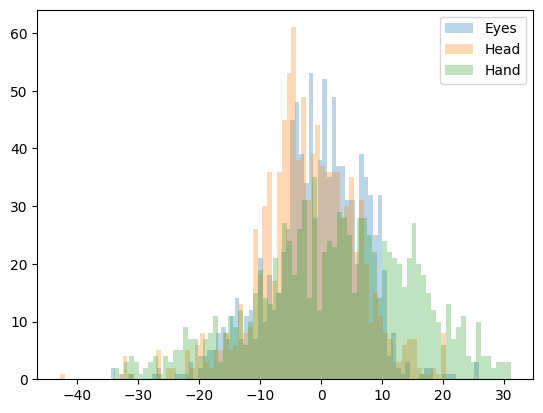

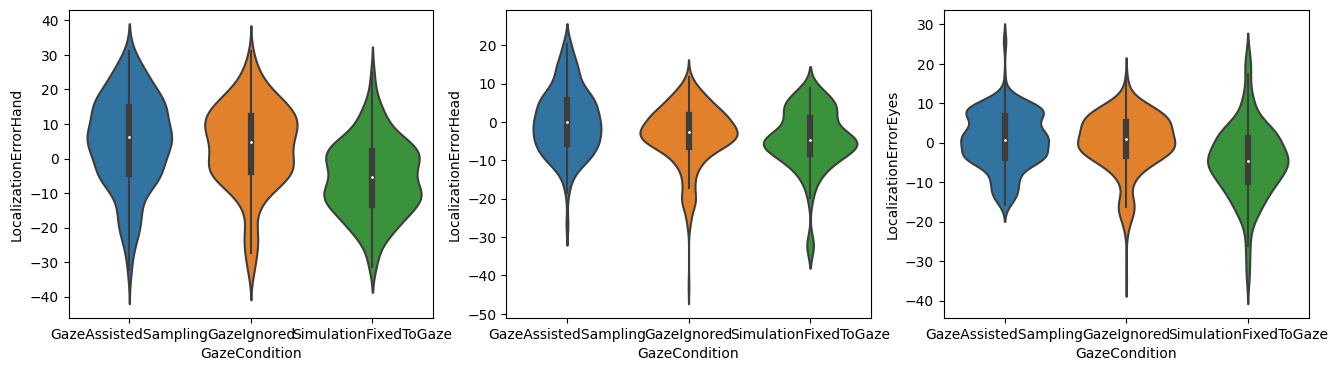

<Axes: xlabel='GazeCondition', ylabel='LocalizationErrorEyes'>

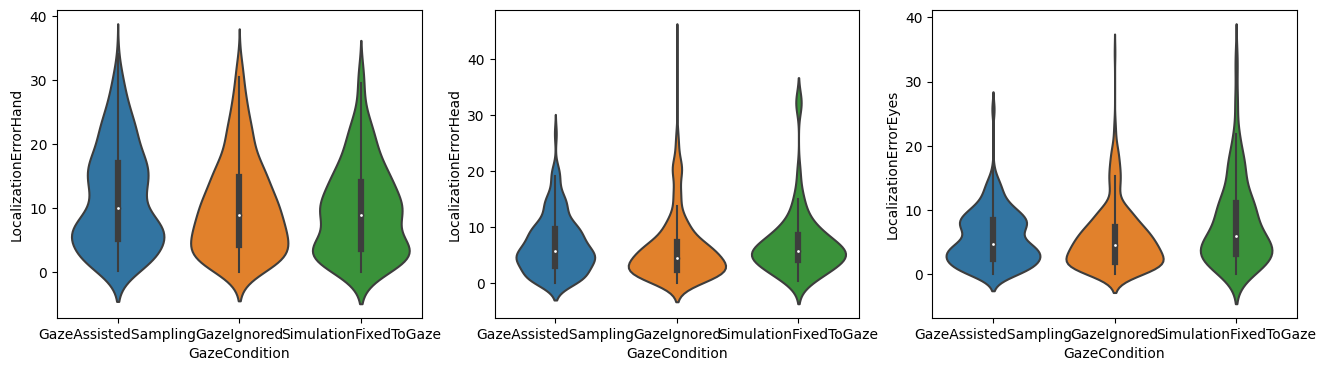

In [178]:
data = valid.loc[event_window_mask]

colors = TARGETS.loc[data.ActiveTarget,'Color']

head_pos = (data.XRHeadPosX + data.XRHeadPosZ*1j).values
head_dir = (data.XRHeadDirX + data.XRHeadDirZ*1j).values
hand_pos = (data.HandRPosX + data.HandRPosZ*1j).values
hand_dir = (data.HandRDirX + data.HandRDirZ*1j).values
org_pos = (data.XROriginPosX + data.XROriginPosZ * 1j).values
org_dir = (data.XROriginDirX + data.XROriginDirZ * 1j).values

trg_pos = (targets.loc[data['ActiveTarget']].PosX + \
                    targets.loc[data['ActiveTarget']].PosZ * 1j).values


hand_point = (data.PointLocationHandX + data.PointLocationHandZ*1j).values
head_point = (data.PointLocationHeadX + data.PointLocationHeadZ*1j).values
eyes_point = (data.PointLocationEyeX + data.PointLocationEyeZ*1j).values



def angle_between(a, b):
    """Calculate the shortest angle between two complex numbers (represented as vectors on the complex plane)
    return value in degrees"""
    theta = np.angle(a) - np.angle(b)
    theta *= 180/np.pi  #convert to degrees
    theta = (theta + 180) % 360 - 180 # find the shortest angle (e.g. -270 -> 90 deg.)
    return theta

valid.loc[event_window_mask, 'LocalizationErrorHand'] = angle_between(hand_point-hand_pos, trg_pos-hand_pos)
valid.loc[event_window_mask, 'LocalizationErrorHead'] = angle_between(head_point-head_pos, trg_pos-head_pos)
valid.loc[event_window_mask, 'LocalizationErrorEyes'] = angle_between(eyes_point-head_pos, trg_pos-head_pos)
data = valid.loc[event_window_mask]
data = data.loc[(abs(data.LocalizationErrorHand) < 35) & (abs(data.LocalizationErrorEyes) <35)]

# miss = (abs(hand_dev) > 20) | (abs(eyes_dev) > 50)


# valid.loc[event_window_mask, 'LocalizationErrorHand'] = hand_dev[~miss]
# # valid.loc[~miss & event_window_mask, 'LocalizationErrorHead'] = head_dev[~miss]
# # valid.loc[~miss & event_window_mask, 'LocalizationErrorEyes'] = eyes_dev[~miss]


plt.hist(data.LocalizationErrorEyes, bins=80, alpha =0.3)
plt.hist(data.LocalizationErrorHead, bins=80, alpha =0.3)
plt.hist(data.LocalizationErrorHand, bins=80, alpha =0.3)
plt.legend(['Eyes', 'Head', 'Hand'])


fig, axs = plt.subplots(1,3,figsize=(16,4), dpi=100)
sns.violinplot(data=data, y='LocalizationErrorHand', x='GazeCondition', ax= axs[0])
sns.violinplot(data=data, y='LocalizationErrorHead', x='GazeCondition', ax= axs[1])
sns.violinplot(data=data, y='LocalizationErrorEyes', x='GazeCondition', ax= axs[2])
plt.show()

fig, axs = plt.subplots(1,3,figsize=(16,4), dpi=100)
sns.violinplot(data=data, y=abs(data.LocalizationErrorHand), x='GazeCondition', ax= axs[0])
sns.violinplot(data=data, y=abs(data.LocalizationErrorHead), x='GazeCondition', ax= axs[1])
sns.violinplot(data=data, y=abs(data.LocalizationErrorEyes), x='GazeCondition', ax= axs[2])

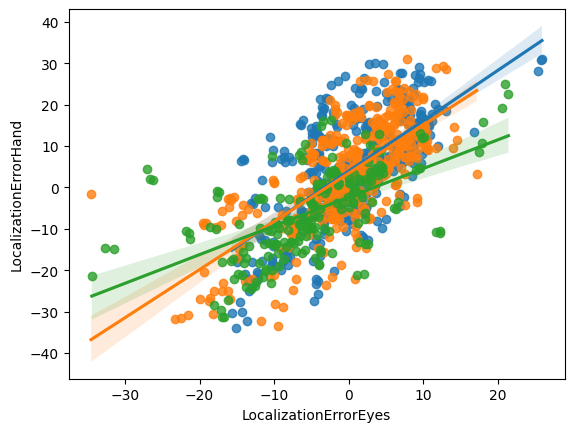

<Axes: xlabel='LocalizationErrorHead', ylabel='LocalizationErrorHand'>

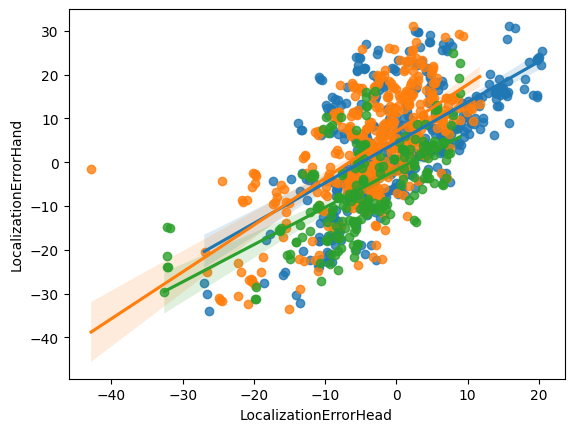

In [180]:
sns.regplot(data=data.loc[data.GazeCondition == 'GazeAssistedSampling'], y='LocalizationErrorHand', x='LocalizationErrorEyes')
sns.regplot(data=data.loc[data.GazeCondition == 'GazeIgnored'], y='LocalizationErrorHand', x='LocalizationErrorEyes')
sns.regplot(data=data.loc[data.GazeCondition == 'SimulationFixedToGaze'], y='LocalizationErrorHand', x='LocalizationErrorEyes')

plt.show()

sns.regplot(data=data.loc[data.GazeCondition == 'GazeAssistedSampling'], y='LocalizationErrorHand', x='LocalizationErrorHead')
sns.regplot(data=data.loc[data.GazeCondition == 'GazeIgnored'], y='LocalizationErrorHand', x='LocalizationErrorHead')
sns.regplot(data=data.loc[data.GazeCondition == 'SimulationFixedToGaze'], y='LocalizationErrorHand', x='LocalizationErrorHead')

TrialIdentifier  ReportedEventsCount           TimeStamp  \
709           S42B2T0                    1  638152555936790717   
710           S42B2T0                    1  638152555938791111   
711           S42B2T0                    1  638152555940798006   
818           S42B2T0                    2  638152556154743099   
819           S42B2T0                    2  638152556156743108   
...               ...                  ...                 ...   
68816         S45B9T2                    7  638156099551153114   
68817         S45B9T2                    7  638156099553154256   
68962         S45B9T2                    8  638156099843110294   
68963         S45B9T2                    8  638156099845120294   
68964         S45B9T2                    8  638156099847120293   

                    XROriginPos           XROriginRot  \
709    (-0.62064, 0.0, 0.87984)  (0.0, 0.0, 0.0, 1.0)   
710    (-0.62064, 0.0, 0.87984)  (0.0, 0.0, 0.0, 1.0)   
711    (-0.62064, 0.0, 0.87984)  (0.0, 0.0, 0.0, 1.0)   
818    (-0.62064, 0.0, 0.87984)  (0.0, 0.0, 0.0, 1.0)   
819    (-0.62064, 0.0, 0.87984)  (0.0, 0.0, 0.0, 1.0)   
...                         ...                   ...   
68816  (-0.62064, 0.0, 0.87984)  (0.0, 0.0, 0.0, 1.0)   
68817  (-0.62064, 0.0, 0.87984)  (0.0, 0.0, 0.0, 1.0)   
68962  (-0.62064, 0.0, 0.87984)  (0.0, 0.0, 0.0, 1.0)   
68963  (-0.62064, 0.0, 0.87984)  (0.0, 0.0, 0.0, 1.0)   
68964  (-0.62064, 0.0, 0.87984)  (0.0, 0.0, 0.0, 1.0)   

                          XRHeadPos                               XRHeadRot  \
709    (-0.69109, 1.58467, 1.03013)   (0.01247, 0.46754, -0.04404, 0.88279)   
710      (-0.69232, 1.584, 1.03174)     (0.01543, 0.46663, -0.045, 0.88317)   
711    (-0.69557, 1.58636, 1.03276)   (0.01005, 0.46357, -0.03924, 0.88514)   
818    (-0.92165, 1.62553, 0.91433)    (-0.0557, 0.98545, 0.15505, -0.0417)   
819     (-0.92439, 1.62617, 0.9153)  (-0.05731, 0.98447, 0.15941, -0.04604)   
...                             ...                                     ...   
68816  (-0.52095, 1.68103, 1.19547)   (0.15248, -0.17998, 0.03398, 0.97119)   
68817  (-0.52911, 1.67842, 1.19132)   (0.16015, -0.22897, 0.04056, 0.95931)   
68962   (-0.42938, 1.70149, 1.0941)   (0.07047, 0.53928, -0.02851, 0.83869)   
68963  (-0.43293, 1.69998, 1.09421)   (0.07614, 0.53598, -0.03085, 0.84023)   
68964   (-0.43471, 1.7014, 1.09308)   (0.06866, 0.53603, -0.03127, 0.84082)   

                           HandLPos                                HandLRot  \
709        (-0.62064, 0.0, 0.87984)                    (0.0, 0.0, 0.0, 1.0)   
710        (-0.62064, 0.0, 0.87984)                    (0.0, 0.0, 0.0, 1.0)   
711        (-0.62064, 0.0, 0.87984)                    (0.0, 0.0, 0.0, 1.0)   
818        (-0.62064, 0.0, 0.87984)                    (0.0, 0.0, 0.0, 1.0)   
819        (-0.62064, 0.0, 0.87984)                    (0.0, 0.0, 0.0, 1.0)   
...                             ...                                     ...   
68816    (-0.7622, 0.8007, 1.20898)    (0.194, -0.04909, -0.31862, 0.92652)   
68817  (-0.76074, 0.79583, 1.18771)   (0.2093, -0.07561, -0.30644, 0.92551)   
68962   (-0.4913, 0.78469, 1.32774)   (-0.0042, 0.52353, -0.37616, 0.76446)   
68963  (-0.49142, 0.78949, 1.33598)  (-0.00736, 0.50757, -0.37117, 0.77753)   
68964  (-0.48774, 0.79229, 1.33929)  (-0.01449, 0.50961, -0.36882, 0.77721)   

                           HandRPos  ... XRHeadDirZ  HandLDirX  HandLDirY  \
709    (-0.50632, 1.33187, 1.15556)  ...   0.562505   0.000000   0.000000   
710    (-0.50896, 1.32802, 1.15816)  ...   0.564035   0.000000   0.000000   
711    (-0.51419, 1.33089, 1.15911)  ...   0.570008   0.000000   0.000000   
818    (-0.95539, 1.41013, 0.72278)  ...  -0.948441   0.000000   0.000000   
819    (-0.95224, 1.42335, 0.71992)  ...  -0.944937   0.000000   0.000000   
...                             ...  ...        ...        ...        ...   
68816  (-0.67625, 1.29086, 1.82724)  ...   0.888715  -0.214589  -0.328206   
68817  (-0.698

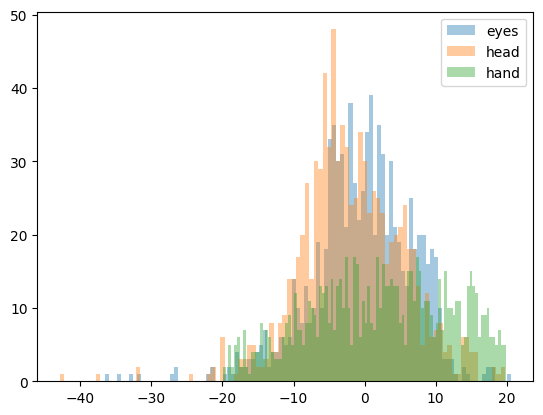

In [133]:
plt.hist(eyes_dev[~miss], bins=100, alpha=0.4)
plt.hist(head_dev[~miss], bins=100, alpha=0.4)
plt.hist(hand_dev[~miss], bins=100, alpha=0.4)
plt.legend(['eyes', 'head', 'hand'])

In [120]:
(abs(hand_dev) > 20).sum()

273

In [ ]:
(hand_dev > 20).sum()

In [33]:
hits.columns


Index(['TrialIdentifier', 'ReportedEventsCount', 'TimeStamp', 'XROriginPos',
       'XROriginRot', 'XRHeadPos', 'XRHeadRot', 'HandLPos', 'HandLRot',
       'HandRPos', 'HandRRot', 'CollisionCount', 'FrameCount', 'ActiveTarget',
       'PointLocationHand', 'PointLocationEye', 'PointLocationHead',
       'TargetHit', 'Unnamed: 17', 'Subject', 'Block', 'RelativeTrialNumber',
       'ExperimentalTask', 'GazeCondition', 'XROriginDir', 'XRHeadDir',
       'HandLDir', 'HandRDir', 'XROriginPosX', 'XROriginPosY', 'XROriginPosZ',
       'XROriginRotW', 'XROriginRotX', 'XROriginRotY', 'XROriginRotZ',
       'XRHeadPosX', 'XRHeadPosY', 'XRHeadPosZ', 'XRHeadRotW', 'XRHeadRotX',
       'XRHeadRotY', 'XRHeadRotZ', 'HandLPosX', 'HandLPosY', 'HandLPosZ',
       'HandLRotW', 'HandLRotX', 'HandLRotY', 'HandLRotZ', 'HandRPosX',
       'HandRPosY', 'HandRPosZ', 'HandRRotW', 'HandRRotX', 'HandRRotY',
       'HandRRotZ', 'PointLocationHandX', 'PointLocationHandY',
       'PointLocationHandZ', 'PointLocationE

In [21]:
colors.reset_index().ActiveTarget.unique()

In [22]:
TARGETS['Color']

In [23]:
hit


In [24]:
trg_dir

In [ ]:
    targets = data.ActiveTarget.unique()

In [ ]:
target_locations = pd.read_csv(os.path.join(DATA_DIR, '_TargetLocations.tsv'), sep='\t').set_index('TargetName')

In [ ]:
axs[0].plot(target_locations['PosX'], target_locations['PosZ'], '.')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

In [ ]:
target_locations.loc[targets]

PosX     PosY     PosZ
TargetName                                         
Mug_1            -2.754    0.461 -2.071
Shoes_2         0.883    0.000    3.309
Mug_2            -0.727    0.708 -2.554
Stool_4        -1.481    0.529 -1.923
Shoes_1         1.013    0.000 -1.693
Shoes_3        -2.032    0.000    0.552
Shoes_4        -0.739    0.000    2.910
Mug_5             1.858    0.789    1.980
Stool_5         0.330    0.530 -1.777
Mug_4            -2.672    0.514    1.228
Shoes_5         1.715    0.000 -0.031
Stool_2         1.487    0.529    2.214
Stool_3         1.783    0.529 -1.180
Stool_1        -1.508    0.529    3.008
Mug_3             2.164    0.554    0.849

In [ ]:
targets.tolist()

AttributeError: ignored

In [ ]:
event_mask = data.groupby('TrialIdentifier').ReportedEventsCount.diff() == 1
event_frames = np.where(event_mask)[0]


for frame in event_frames:
    data.iloc[frame]

In [ ]:
VS_data = engine_data[:len(engine_data)//4]

# Subdata with only the 'event' frames 
window = 5 # frames after trigger was pressed
event_frames = VS_data.ReportedEventsCount.diff() == 1
event_window_frames = [frames for event_frame in np.where(event_frames)[0] for frames in range(event_frame-window, event_frame + window)]
VS_events_data = VS_data.iloc[event_window_frames]

NameError: ignored

In [26]:
def plot_quiver_map(data, axs=None, color=None, fig=None):
    if axs is None:
        fig, axs = plt.subplots(1,2, figsize=(8,4), dpi=200,)
    
    # Unique color per target
    targets = data.ActiveTarget.unique()
    colormapping = {trg: i/len(targets) for i,trg in enumerate(targets)}
    coloridx = data.ActiveTarget.replace(colormapping)
    
    # Head quiver (first axis)
    x, y = data['XRHeadPosX'], data['XRHeadPosZ']
    u, v = np.cos(data['XRHeadDirY']), np.sin(data['XRHeadDirY'])
    if color is None: 
        axs[0].quiver(x,y,u,v, coloridx, scale=15, alpha = .1,)
    else:
        axs[0].quiver(x,y,u,v, color=color, scale=15, alpha = .2,)
    axs[0].axis('square')
    axs[0].set(title= 'Head')
    
    # Hand Quiver
    x, y = data['HandRPosX'], data['HandRPosZ']
    u, v = np.cos(data['HandRDirY']), np.sin(data['HandRDirY'])
    if color is None: 
        axs[1].quiver(x,y,u,v, coloridx, scale=10, alpha = .1)
    else:
        axs[1].quiver(x,y,u,v, color=color, scale=10, alpha = .2)
    axs[1].axis('square')
    axs[1].set(title= 'Right Hand')


    return fig, axs
    

# Subdata with only the 'event' frames 
window = 5 # frames after trigger was pressed
event_frames = VS_data.ReportedEventsCount.diff() == 1
event_window_frames = [frames for event_frame in np.where(event_frames)[0] for frames in range(event_frame-window, event_frame + window)]
VS_events_data = VS_data.iloc[event_window_frames]

print(f'Including {window} frames after trigger:')
fig, axs = plot_quiver_map(VS_data.iloc[event_window_frames])
plot_quiver_map(VS_data.loc[event_frames], color='red', axs=axs)

after = np.where(event_frames)[0] + window
before = np.where(event_frames)[0] - window
plot_quiver_map(VS_data.iloc[before], color='green', axs=axs)
plot_quiver_map(VS_data.iloc[after], color='blue', axs=axs)

plt.show()


# _ = plot_quiver_map(SR_data)

# # rand = np.random.randint(0,len(VS_data), event_frames.sum())
# # event_frames = np.zeros_like(event_frames)
# # event_frames[rand] = True
# event_window_frames = [frames for event_frame in np.where(event_frames)[0] for frames in range(event_frame - window, event_frame)]
# VS_events_data = VS_data.iloc[event_window_frames]

# print(f'Including {window} frames before trigger:')
# _= plot_quiver_map(VS_events_data)

In [27]:
subjects = ['test']
data = engine_data.loc[eye_data.Block>0] # Exclude practice block
data = data.loc[(data.Subject.isin(subjects))] # Specified subjects
VS_data = data.loc[data.ExperimentalTask == 'VisualSearch']
SR_data = data.loc[data.ExperimentalTask == 'SceneRecognition']





In [28]:
quat = VS_events_data.XRHeadRot.iloc[0]

quat_to_rotvec(quat)


In [ ]:
quat_to_euler(quat)

In [ ]:
def quat_to_rotvec(x):
    if type(x) == str:
        quat_tuple = ast.literal_eval(x) # convert string -> tuple
    quat_obj = Rotation.from_quat(quat_tuple)
    return quat_obj.as_rotvec(degrees=True)

In [ ]:
# Subdata with only the 'event' frames 
window = 5 # frames after trigger was pressed
event_frames = VS_data.ReportedEventsCount.diff() == 1
event_window_frames = [frames for event_frame in np.where(event_frames)[0] for frames in range(event_frame-window, event_frame + window)]
VS_events_data = VS_data.iloc[event_window_frames]



NameError: ignored

In [ ]:
VS_events_data.XRHeadRot.apply()

Quiver map around the event frames:

In [ ]:
def plot_quiver_map(data, axs=None, color=None, fig=None):
    if axs is None:
        fig, axs = plt.subplots(1,2, figsize=(8,4), dpi=200,)
    
    # Unique color per target
    targets = data.ActiveTarget.unique()
    colormapping = {trg: i/len(targets) for i,trg in enumerate(targets)}
    coloridx = data.ActiveTarget.replace(colormapping)
    
    # Head quiver (first axis)
    x, y = data['XRHeadPosX'], data['XRHeadPosZ']
    u, v = np.cos(data['XRHeadRotEulerY']), np.sin(data['XRHeadRotEulerY'])
    if color is None: 
        axs[0].quiver(x,y,u,v, coloridx, scale=15, alpha = .1,)
    else:
        axs[0].quiver(x,y,u,v, color=color, scale=15, alpha = .2,)
    axs[0].axis('square')
    axs[0].set(title= 'Head')
    
    # Hand Quiver
    x, y = data['HandRPosX'], data['HandRPosZ']
    u, v = np.cos(data['HandRRotEulerY']), np.sin(data['HandRRotEulerY'])
    if color is None: 
        axs[1].quiver(x,y,u,v, coloridx, scale=10, alpha = .1)
    else:
        axs[1].quiver(x,y,u,v, color=color, scale=10, alpha = .2)
    axs[1].axis('square')
    axs[1].set(title= 'Right Hand')


    return fig, axs
    

# Subdata with only the 'event' frames 
window = 5 # frames after trigger was pressed
event_frames = VS_data.ReportedEventsCount.diff() == 1
event_window_frames = [frames for event_frame in np.where(event_frames)[0] for frames in range(event_frame-window, event_frame + window)]
VS_events_data = VS_data.iloc[event_window_frames]

print(f'Including {window} frames after trigger:')
fig, axs = plot_quiver_map(VS_data.iloc[event_window_frames])
plot_quiver_map(VS_data.loc[event_frames], color='red', axs=axs)

after = np.where(event_frames)[0] + window
before = np.where(event_frames)[0] - window
plot_quiver_map(VS_data.iloc[before], color='green', axs=axs)
plot_quiver_map(VS_data.iloc[after], color='blue', axs=axs)

plt.show()


# _ = plot_quiver_map(SR_data)

# # rand = np.random.randint(0,len(VS_data), event_frames.sum())
# # event_frames = np.zeros_like(event_frames)
# # event_frames[rand] = True
# event_window_frames = [frames for event_frame in np.where(event_frames)[0] for frames in range(event_frame - window, event_frame)]
# VS_events_data = VS_data.iloc[event_window_frames]

# print(f'Including {window} frames before trigger:')
# _= plot_quiver_map(VS_events_data)

NameError: ignored

In [ ]:
ev_data = VS_data.iloc[event_window_frames]
plt.plot(ev_data.TimeStamp, ev_data.XRHeadRotEulerY, '-')

NameError: ignored

In [ ]:
event_frames

array([ True,    True,    True, ...,    True, False, False])

In [ ]:

plt.plot(VSdata.loc[event_mask, 'XRHeadRotEulerY'])

In [ ]:
def plot_gaze_maps(data):
    fig, axs = plt.subplots(1,3,figsize=(12,4), dpi=100)
    for i, condition in enumerate(data.GazeCondition.unique()):
        mask = data.GazeCondition == condition

        axs[i].scatter(data.loc[mask, 'GazeDirectionNormInEyeX'],
                                data.loc[mask, 'GazeDirectionNormInEyeY'], alpha = 0.002, color='#9e1111')
        axs[i].axis('square')
        axs[i].set(xlim = [-0.8,0.8],
                            ylim = [-0.8,0.8], 
                            title= condition)
    plt.show()
    return fig, axs

# Which data to show
subjects = ['S31']
data = eye_data.loc[eye_data.Block>0] # Exclude practice block
data = data.loc[(data.Subject.isin(subjects))] # Specified subjects
VSdata = data.loc[data.ExperimentalTask == 'VisualSearch']
SRdata = data.loc[data.ExperimentalTask == 'SceneRecognition']

print(f'all data (subjects: {subjects}):')
plot_gaze_maps(data)

print('visual search trials:')
plot_gaze_maps(VSdata)

print('scene recognition trials:')
_= plot_gaze_maps(SRdata)

{'S31B0T0': 'GazeIgnored',
 'S31B0T1': 'GazeIgnored',
 'S31B0T2': 'GazeIgnored',
 'S31B0T3': 'GazeAssistedSampling',
 'S31B0T4': 'GazeAssistedSampling',
 'S31B0T5': 'SimulationFixedToGaze',
 'S31B0T6': 'SimulationFixedToGaze',
 'S31B0T7': 'GazeIgnored',
 'S31B1T0': 'SimulationFixedToGaze',
 'S31B1T1': 'SimulationFixedToGaze',
 'S31B1T3': 'SimulationFixedToGaze',
 'S31B2T0': 'GazeIgnored',
 'S31B2T1': 'GazeIgnored',
 'S31B2T2': 'GazeIgnored',
 'S31B2T3': 'GazeIgnored',
 'S31B3T0': 'GazeAssistedSampling',
 'S31B3T1': 'GazeAssistedSampling',
 'S31B3T2': 'GazeAssistedSampling',
 'S31B3T3': 'GazeAssistedSampling',
 'S31B4T0': 'GazeIgnored',
 'S31B4T1': 'GazeIgnored',
 'S31B4T2': 'GazeIgnored',
 'S31B4T3': 'GazeIgnored',
 'S31B5T0': 'GazeAssistedSampling',
 'S31B5T1': 'GazeAssistedSampling',
 'S31B5T2': 'GazeAssistedSampling',
 'S31B5T3': 'GazeAssistedSampling',
 'S31B6T0': 'SimulationFixedToGaze',
 'S31B6T1': 'SimulationFixedToGaze',
 'S31B6T2': 'SimulationFixedToGaze',
 'S31B6T3': 'Simulat

In [ ]:

prop_from_ID(eye_data[0].TrialIdentifier, 'GazeCondition')

KeyError: ignored

In [ ]:
eye_data[['GazeDirX', 'GazeDirY', 'GazeDirZ']] = eye_data['GazeDirectionNormInEye'].apply(pd.Series)

In [ ]:
# Put your dataframe here
df = pd.DataFrame({'A':[1,2], 'B':[(1,2), (3,4)]}) 
df.B

0        (1, 2)
1        (3, 4)
Name: B, dtype: object

In [ ]:
eye_data.GazeDirectionNormInEye[:10].apply(pd.Series)

0
0    (0.01634, 0.08493, 0.99625)
1    (0.01268, 0.05301, 0.99850)
2    (0.01411, 0.03772, 0.99918)
3    (0.01411, 0.03772, 0.99918)
4    (0.01411, 0.03772, 0.99918)
5    (0.02559, 0.01903, 0.99948)
6    (0.02559, 0.01903, 0.99948)
7    (0.02559, 0.01903, 0.99948)
8    (0.02559, 0.01903, 0.99948)
9    (0.01859, 0.00856, 0.99979)

In [ ]:
trial_data

GazeCondition EnvironmentName EnvironmentClass    Glasses    \
0                         GazeIgnored            Playground                         None    Glasses     
1                         GazeIgnored            Playground                         None    Glasses     
2                         GazeIgnored             bedroom_4                    Bedroom    Glasses     
3        GazeAssistedSampling            Playground                         None    Glasses     
4        GazeAssistedSampling            bathroom_3                 Bathroom    Glasses     
5     SimulationFixedToGaze            Playground                         None    Glasses     
6        GazeAssistedSampling                living_5                     Living    Glasses     
7                         GazeIgnored            Playground                         None    Glasses     
8        GazeAssistedSampling            Playground                         None    Glasses     
9        GazeAssistedSampling             bedroom_3                    Bedroom    Glasses     
10     GazeAssistedSampling                living_3                     Living    Glasses     
11     GazeAssistedSampling             bedroom_2                    Bedroom    Glasses     
12                        GazeIgnored             bedroom_1                    Bedroom    Glasses     
13                        GazeIgnored             kitchen_1                    Kitchen    Glasses     
14                        GazeIgnored             kitchen_2                    Kitchen    Glasses     
15    SimulationFixedToGaze            Playground                         None    Glasses     
16    SimulationFixedToGaze             kitchen_3                    Kitchen    Glasses     
17    SimulationFixedToGaze            bathroom_2                 Bathroom    Glasses     
18    SimulationFixedToGaze                living_2                     Living    Glasses     
19                        GazeIgnored            Playground                         None    Glasses     
20                        GazeIgnored             bedroom_2                    Bedroom    Glasses     
21                        GazeIgnored                living_2                     Living    Glasses     
22                        GazeIgnored             bedroom_3                    Bedroom    Glasses     
23    SimulationFixedToGaze            Playground                         None    Glasses     
24    SimulationFixedToGaze             kitchen_3                    Kitchen    Glasses     
25    SimulationFixedToGaze                living_1                     Living    Glasses     
26    SimulationFixedToGaze             kitchen_2                    Kitchen    Glasses     
27                        GazeIgnored            Playground                         None    Glasses     
28    SimulationFixedToGaze            Playground                         None    Glasses     
29     GazeAssistedSampling            Playground                         None    Glasses     
30                        GazeIgnored            Playground                         None    Glasses     
31     GazeAssistedSampling            Playground                         None    Glasses     
32    SimulationFixedToGaze            Playground                         None    Glasses     

        GazeRaySensitivity DataDelimiter ReportedRoomCategory    \
0                                    1.0                                                             None     
1                                    1.0                                                             None     
2                                    1.0                                                         Living     
3                                    1.0                                                         Living     
4                                    1.0                                                        Bedroom     
5                                    1.0                                   

In [ ]:
def load_eye_tracking_data_from_filenames(filenames):
    eye_data =


eye_data = pd.DataFrame()

for i in range(len(eye_fn)):
    new = pd.read_csv(eye_fn[i],sep = '\t', converters={"GazeDirectionNormInEye": ast.literal_eval})
    new['block'] = int(eye_fn[i][1:3])
    ID = eye_fn[i][1:6]
    new['Trial_ID'] = ID
    new['GazeCondition'] = trial_data.loc[trial_data['Trial_ID'] == ID, 
                                                                                'GazeCondition']
    eye_data = pd.concat([eye_data,new], ignore_index=True)



trial_data


In [ ]:
for i in range(len(eye_data)):
    x, y, z = eye_data.GazeDirectionNormInEye[i].replace('(', '').replace(')', '').split(',')
    eye_data.loc[i, 'x'] = float(x)
    eye_data.loc[i, 'y'] = float(y)
    eye_data.loc[i, 'z'] = float(z)

KeyboardInterrupt: ignored

In [ ]:
eye_data_cp = eye_data.copy()

In [ ]:
import ast

In [ ]:
gazeDirection = eye_data.GazeDirectionNormInEye.apply(pd.Series, index=['x','y','z'])

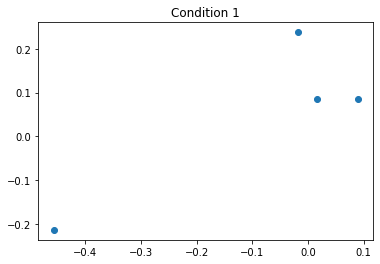

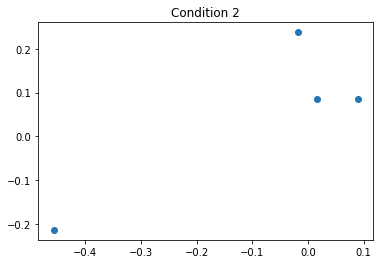

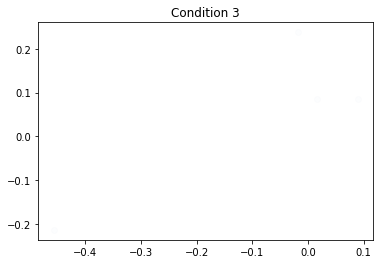

In [ ]:
c1 = eye_data.loc[eye_data.GazeCondition=='GazeIgnored']
c2 = eye_data.loc[eye_data.GazeCondition=='SimulationFixedToGaze']
c3 = eye_data.loc[eye_data.GazeCondition=='GazeAssistedSampling']


plt.scatter(c1.x, c1.y)
plt.title('Condition 1')
plt.show()


plt.scatter(c1.x, c1.y)
plt.title('Condition 2')
plt.show()

plt.scatter(c1.x, c1.y, alpha = 0.01)
plt.title('Condition 3')
plt.show()

In [ ]:
sr_mask = trial_data.EnvironmentName != 'Playground'
vs_mask = ~sr_mask & (trial_data.block > 6)

trial_data.loc[sr_mask,'Correct'] = (trial_data.loc[sr_mask,'ReportedRoomCategory'] ==
                                                             trial_data.loc[sr_mask,'EnvironmentClass']).astype(float)

VSData = trial_data.loc[vs_mask]
SRData = trial_data.loc[sr_mask] 

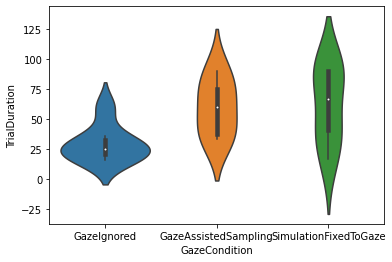

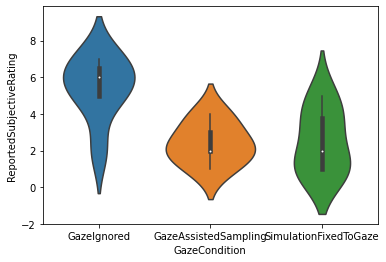

<AxesSubplot:xlabel='GazeCondition', ylabel='Correct'>

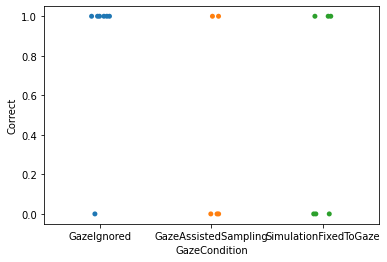

In [ ]:
sns.violinplot(data=SRData, x='GazeCondition', y='TrialDuration')
plt.show()
sns.violinplot(data=SRData, x='GazeCondition', y='ReportedSubjectiveRating')
plt.show()
sns.stripplot(data=SRData, x='GazeCondition', y='Correct')

In [ ]:
SRData.groupby('GazeCondition').mean()

GazeRaySensitivity    ReportedSubjectiveRating    \
GazeCondition                                                                                                                 
GazeAssistedSampling                                    1.0                                    2.400000     
GazeIgnored                                                     1.0                                    5.428571     
SimulationFixedToGaze                                 1.0                                    2.500000     

                                             ReportedEventsCount    TrialDuration    Unnamed: 10    \
GazeCondition                                                                                                                        
GazeAssistedSampling                            0.800000            59.185452                    NaN     
GazeIgnored                                             0.857143            29.313163                    NaN     
SimulationFixedToGaze                         0.500000            61.535683                    NaN     

                                                    block     Correct    
GazeCondition                                                            
GazeAssistedSampling     0.600000    0.400000    
GazeIgnored                        2.571429    0.857143    
SimulationFixedToGaze    4.000000    0.500000

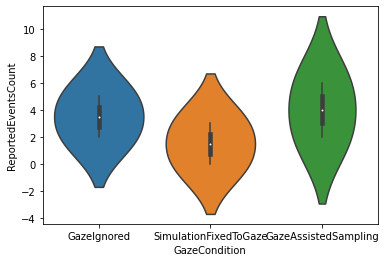

<AxesSubplot:xlabel='GazeCondition', ylabel='ReportedSubjectiveRating'>

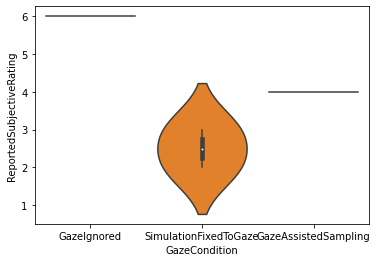

In [ ]:
sns.violinplot(data=VSData, x='GazeCondition', y='ReportedEventsCount')
plt.show()
sns.violinplot(data=VSData, x='GazeCondition', y='ReportedSubjectiveRating')